In [ ]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import chex
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any, Dict
from flax.training.train_state import TrainState
import distrax

from jaxmarl import make
from jaxmarl.wrappers.baselines import (
    SMAXLogWrapper,
    MPELogWrapper,
    LogWrapper,
    CTRolloutManager,
)
from jaxmarl.environments.smax import map_name_to_scenario, HeuristicEnemySMAX, LearnedPolicyEnemySMAX
from jaxmarl.environments.smax.heuristic_enemy_smax_env import EnemySMAX
from jaxmarl.viz.visualizer import Visualizer, SMAXVisualizer

import functools
from functools import partial
import time
import os
import matplotlib.pyplot as plt

from qdax.core.map_elites import MAPElites
from qdax.core.containers.mapelites_repertoire import compute_cvt_centroids, compute_euclidean_centroids, MapElitesRepertoire
#import qdax.tasks.brax.v1 as environments
#from qdax.tasks.brax.v1.env_creators import scoring_function_brax_envs as scoring_function
from qdax.core.neuroevolution.buffers.buffer import QDTransition
from qdax.core.neuroevolution.networks.networks import MLP
from qdax.core.emitters.mutation_operators import isoline_variation
from qdax.core.emitters.standard_emitters import MixingEmitter
from qdax.utils.plotting import plot_map_elites_results
from qdax.utils.metrics import CSVLogger, default_qd_metrics



from dataclasses import dataclass

from qdax.core.emitters.repertoire_selectors.selector import Selector
from qdax.core.emitters.qpg_emitter import QualityPGConfig, QualityPGEmitterState
from qdax.tasks.brax.v1.envs.base_env import QDEnv

from qdax.core.emitters.multi_emitter import MultiEmitter
from qdax.core.containers.ga_repertoire import GARepertoire
from qdax.core.containers.repertoire import Repertoire
#from qdax.core.neuroevolution.losses.td3_loss import make_td3_loss_fn
from qdax.core.emitters.emitter import Emitter
#from qdax.core.neuroevolution.networks.networks import QModule
#from qdax.core.neuroevolution.buffers.buffer import ReplayBuffer

from qdax.core.emitters.pga_me_emitter import PGAMEConfig, PGAMEEmitter

import flashbax as fbx
## Brax version conflict with JaxMARL(0.10.3) and QDax(0.10.4 / 0.12.3)

In [2]:
from typing import Callable, Optional, Tuple
from qdax.custom_types import (
    Descriptor,
    EnvState,
    ExtraScores,
    Fitness,
    Genotype,
    Observation,
    Params,
    RNGKey,
)

In [3]:
config = {
    # valid for iql, vdn, qmix
    "TOTAL_TIMESTEPS": 1e7, #1e7,
    "NUM_ENVS": 4, #16,
    "NUM_STEPS": 128,
    "BUFFER_SIZE": 10000, #5000,
    "BUFFER_BATCH_SIZE": 32,
    "HIDDEN_SIZE": 64, #128, #512,
    "MIXER_EMBEDDING_DIM": 16, #64,
    "MIXER_HYPERNET_HIDDEN_DIM": 64, #256,
    "MIXER_INIT_SCALE": 0.001,
    "EPS_START": 1.0,
    "EPS_FINISH": 0.05,
    "EPS_DECAY": 0.1, # percentage of updates
    "MAX_GRAD_NORM": 10,
    "TARGET_UPDATE_INTERVAL": 10, #10,
    "TAU": 1., #1.,
    "NUM_EPOCHS": 8,
    "LR": 0.00005,
    "LEARNING_STARTS": 10000, # timesteps
    "LR_LINEAR_DECAY": False,
    "GAMMA": 0.99,
    "REW_SCALE": 10., # scale the reward to the original scale of SMAC

    # ENV
    "ENV_NAME": "HeuristicEnemySMAX",
    #"MAP_NAME": "3s_vs_5z",
    #"MAP_NAME":"smacv2_5_units", # 5 random units for each size
    "MAP_NAME": "2s3z",
    #"MAP_NAME": "5m_vs_6m",
    "ENV_KWARGS": {
        "see_enemy_actions": True,
        "walls_cause_death": True,
        #"attack_mode": "closest", # uncomment when using heuristic policy
        #"won_battle_bonus": 10.0, # To test if increasing winning reward gets solution to beat enemy
    },

    "NUM_SEEDS": 1, # number of vmapped seeds (not used)
    "SEED": 88,

    "HYP_TUNE": False, # perform hyp tune

    # evaluate
    "TEST_DURING_TRAINING": False, #True,
    "TEST_INTERVAL": 0.05, # as a fraction of updates, i.e. log every 5% of training process
    "TEST_NUM_STEPS": 128,
    "TEST_NUM_ENVS": 512, # number of episodes to average over, can affect performance
}
batch_size = 20# 128 # Num of offsprings 
#env_name = 'walker2d_uni'
episode_length = config["NUM_STEPS"] #128  # NUM_STEPS
num_iterations = int(config["TOTAL_TIMESTEPS"] / (batch_size * config["NUM_ENVS"] * config["NUM_STEPS"]))
seed = 88 
policy_hidden_layer_sizes = (128, 128, 128) #(64, 64)
iso_sigma = 0.05 #0.005 
line_sigma = 0.5 #0.05 
num_init_cvt_samples = 20000 #50000 
num_centroids = 1024 #1024 
min_descriptor = 0. 
max_descriptor = 1.0 
number_of_descriptors=2


proportion_mutation_ga = 0.5 

# IQL/TD3 params
env_batch_size = batch_size #100 
replay_buffer_size = config["BUFFER_SIZE"] #1000000 
critic_hidden_layer_size = (256, 256) 
critic_learning_rate = 3e-4 
greedy_learning_rate = 3e-4 
policy_learning_rate = 1e-3 
noise_clip = 0.5
policy_noise = 0.2 
discount = config["GAMMA"] #0.99 
reward_scaling = 1.0 
transitions_batch_size = config["BUFFER_BATCH_SIZE"] #256 
soft_tau_update = 0.005
num_critic_training_steps = 300 
num_pg_training_steps = 10 #100 
policy_delay = 2

# Define the PG-emitter config
@dataclass
class CustomPGAMEConfig(PGAMEConfig):
    num_envs: Any = None
    num_steps: Any = None
    target_update_interval: Any = None
    tau: Any = None

pga_emitter_config = CustomPGAMEConfig(
    env_batch_size=env_batch_size,
    batch_size=transitions_batch_size,
    proportion_mutation_ga=proportion_mutation_ga,
    critic_hidden_layer_size=critic_hidden_layer_size,
    critic_learning_rate=critic_learning_rate,
    greedy_learning_rate=greedy_learning_rate,
    policy_learning_rate=policy_learning_rate,
    noise_clip=noise_clip,
    policy_noise=policy_noise,
    discount=discount,
    reward_scaling=reward_scaling,
    replay_buffer_size=replay_buffer_size,
    soft_tau_update=soft_tau_update,
    num_critic_training_steps=num_critic_training_steps,
    num_pg_training_steps=num_pg_training_steps,
    policy_delay=policy_delay,

    num_envs = config["NUM_ENVS"],
    num_steps = config["NUM_STEPS"],
    target_update_interval = config["TARGET_UPDATE_INTERVAL"],
    tau = config["TAU"],
)



In [4]:
class ScannedRNN(nn.Module):

    @partial(
        nn.scan,
        variable_broadcast="params",
        in_axes=0,
        out_axes=0,
        split_rngs={"params": False},
    )
    @nn.compact
    def __call__(self, carry, x):
        """Applies the module."""
        rnn_state = carry
        ins, resets = x
        hidden_size = ins.shape[-1]
        rnn_state = jnp.where(
            resets[:, np.newaxis],
            self.initialize_carry(hidden_size, *ins.shape[:-1]),
            rnn_state,
        )
        new_rnn_state, y = nn.GRUCell(hidden_size)(rnn_state, ins)
        return new_rnn_state, y

    @staticmethod
    def initialize_carry(hidden_size, *batch_size):
        # Use a dummy key since the default state init fn is just zeros.
        return nn.GRUCell(hidden_size, parent=None).initialize_carry(
            jax.random.PRNGKey(0), (*batch_size, hidden_size)
        )


class RNNQNetwork(nn.Module):
    # homogenous agent for parameters sharing, assumes all agents have same obs and action dim
    action_dim: int
    hidden_dim: int
    init_scale: float = 1.0

    @nn.compact
    def __call__(self, hidden, obs, dones):
        embedding = nn.Dense(
            self.hidden_dim,
            kernel_init=orthogonal(self.init_scale),
            bias_init=constant(0.0),
        )(obs)
        embedding = nn.relu(embedding)

        rnn_in = (embedding, dones)
        hidden, embedding = ScannedRNN()(hidden, rnn_in)

        q_vals = nn.Dense(
            self.action_dim,
            kernel_init=orthogonal(self.init_scale),
            bias_init=constant(0.0),
        )(embedding)

        return hidden, q_vals
    

class HyperNetwork(nn.Module):
    """HyperNetwork for generating weights of QMix' mixing network."""

    hidden_dim: int
    output_dim: int
    init_scale: float

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(
            self.hidden_dim,
            kernel_init=orthogonal(self.init_scale),
            bias_init=constant(0.0),
        )(x)
        x = nn.relu(x)
        x = nn.Dense(
            self.output_dim,
            kernel_init=orthogonal(self.init_scale),
            bias_init=constant(0.0),
        )(x)
        return x
'''   
# 1 layer hypernetwork
class HyperNetwork(nn.Module):
    """HyperNetwork for generating weights of QMix' mixing network."""

    hidden_dim: int
    output_dim: int
    init_scale: float

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(
            self.output_dim,
            kernel_init=orthogonal(self.init_scale),
            bias_init=constant(0.0),
        )(x)
        return x
'''

class MixingNetwork(nn.Module):
    """
    Mixing network for projecting individual agent Q-values into Q_tot. Follows the original QMix implementation.
    """

    embedding_dim: int
    hypernet_hidden_dim: int
    init_scale: float

    @nn.compact
    def __call__(self, q_vals, states):

        n_agents, time_steps, batch_size = q_vals.shape
        q_vals = jnp.transpose(q_vals, (1, 2, 0))  # (time_steps, batch_size, n_agents)

        # hypernetwork
        w_1 = HyperNetwork(
            hidden_dim=self.hypernet_hidden_dim,
            output_dim=self.embedding_dim * n_agents,
            init_scale=self.init_scale,
        )(states)
        b_1 = nn.Dense(
            self.embedding_dim,
            kernel_init=orthogonal(self.init_scale),
            bias_init=constant(0.0),
        )(states)
        w_2 = HyperNetwork(
            hidden_dim=self.hypernet_hidden_dim,
            output_dim=self.embedding_dim,
            init_scale=self.init_scale,
        )(states)
        b_2 = HyperNetwork(
            hidden_dim=self.embedding_dim, output_dim=1, init_scale=self.init_scale
        )(states)

        # monotonicity and reshaping
        w_1 = jnp.abs(w_1.reshape(time_steps, batch_size, n_agents, self.embedding_dim))
        b_1 = b_1.reshape(time_steps, batch_size, 1, self.embedding_dim)
        w_2 = jnp.abs(w_2.reshape(time_steps, batch_size, self.embedding_dim, 1))
        b_2 = b_2.reshape(time_steps, batch_size, 1, 1)

        # mix
        hidden = nn.elu(jnp.matmul(q_vals[:, :, None, :], w_1) + b_1)
        q_tot = jnp.matmul(hidden, w_2) + b_2

        return q_tot.squeeze()  # (time_steps, batch_size)

In [5]:
#class Transition(NamedTuple):
#    global_done: jnp.ndarray
#    done: jnp.ndarray
#    action: jnp.ndarray
#    reward: jnp.ndarray
#    obs: jnp.ndarray
#    env_state: jnp.ndarray
#    info: jnp.ndarray
#    avail_actions: jnp.ndarray

class Transition(NamedTuple):
    #global_done: jnp.ndarray
    #reward: jnp.ndarray
    env_state: jnp.ndarray
    infos: jnp.ndarray

@chex.dataclass(frozen=True)
class Timestep:
    obs: dict
    actions: dict
    rewards: dict
    dones: dict
    avail_actions: dict


class CustomTrainState(TrainState):
    target_network_params: Any
    timesteps: int = 0
    n_updates: int = 0
    grad_steps: int = 0


In [6]:
# Load trained IPPO policy
from flax.serialization import from_bytes

class ScannedRNNIPPO(nn.Module):
    @functools.partial(
        nn.scan,
        variable_broadcast="params",
        in_axes=0,
        out_axes=0,
        split_rngs={"params": False},
    )
    @nn.compact
    def __call__(self, carry, x):
        """Applies the module."""
        rnn_state = carry
        ins, resets = x
        resets = jnp.atleast_1d(resets)
        rnn_state = jnp.where(
            resets[:, np.newaxis],
            self.initialize_carry(*rnn_state.shape),
            rnn_state,
        )
        new_rnn_state, y = nn.GRUCell(features=ins.shape[1])(rnn_state, ins)
        return new_rnn_state, y

    @staticmethod
    def initialize_carry(batch_size, hidden_size):
        # Use a dummy key since the default state init fn is just zeros.
        cell = nn.GRUCell(features=hidden_size)
        return cell.initialize_carry(jax.random.PRNGKey(0), (batch_size, hidden_size))


class ActorCriticRNN(nn.Module):
    action_dim: Sequence[int]
    config: Dict

    @nn.compact
    def __call__(self, hidden, x):
        obs, dones, avail_actions = x
        embedding = nn.Dense(
            self.config["FC_DIM_SIZE"], kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(obs)
        embedding = nn.relu(embedding)

        rnn_in = (embedding, dones)
        hidden, embedding = ScannedRNNIPPO(name="ScannedRNN_0")(hidden, rnn_in)

        actor_mean = nn.Dense(self.config["GRU_HIDDEN_DIM"], kernel_init=orthogonal(2), bias_init=constant(0.0))(
            embedding
        )
        actor_mean = nn.relu(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        unavail_actions = 1 - avail_actions
        action_logits = actor_mean - (unavail_actions * 1e10)

        pi = distrax.Categorical(logits=action_logits)

        critic = nn.Dense(self.config["FC_DIM_SIZE"], kernel_init=orthogonal(2), bias_init=constant(0.0))(
            embedding
        )
        critic = nn.relu(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic
        )

        return hidden, pi, jnp.squeeze(critic, axis=-1)
    
ippo_config = {
    "LR": 0.004,
    "NUM_ENVS": 128,
    "NUM_STEPS": 128,
    "GRU_HIDDEN_DIM": 128,
    "FC_DIM_SIZE": 128,
    "TOTAL_TIMESTEPS": 1e7,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": 4,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.05,
    "SCALE_CLIP_EPS": False,
    "ENT_COEF": 0.01,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.25,
    "ACTIVATION": "relu",
    "ENV_NAME": "HeuristicEnemySMAX",
    "MAP_NAME": "2s3z",
    "SEED": 88,
    "ENV_KWARGS": {
        "see_enemy_actions": True,
        "walls_cause_death": True,
        "attack_mode": "closest"
    },
    "ANNEAL_LR": True,
}

# Create dummy env
scenario = map_name_to_scenario(ippo_config["MAP_NAME"])
dummy_env = HeuristicEnemySMAX(scenario=scenario, **ippo_config["ENV_KWARGS"])
dummy_env = SMAXLogWrapper(dummy_env)

# Create dummy model instance
dummy_network = ActorCriticRNN(dummy_env.action_space(dummy_env.agents[0]).n, config=ippo_config)

# Prepare dummy input for param loading
dummy_hstate = ScannedRNNIPPO.initialize_carry(ippo_config["NUM_ENVS"], ippo_config["GRU_HIDDEN_DIM"])
dummy_obs = jnp.zeros((1, ippo_config["NUM_ENVS"], dummy_env.observation_space(dummy_env.agents[0]).shape[0]))
dummy_dones = jnp.zeros((1, ippo_config["NUM_ENVS"]))
dummy_avail = jnp.zeros((1, ippo_config["NUM_ENVS"], dummy_env.action_space(dummy_env.agents[0]).n))
dummy_input = (dummy_obs, dummy_dones, dummy_avail)

# Create dummy params to use as template
rng = jax.random.PRNGKey(0)
dummy_params = dummy_network.init(rng, dummy_hstate, dummy_input)
#trained_ippo_params = dummy_params

# Load trained parameters
with open("/vol/bitbucket/eww24/Masters_project/model_params/trained_ippo_params.msgpack", "rb") as f:
    trained_ippo_params = from_bytes(dummy_params, f.read())
print("Params loaded")


Params loaded


In [7]:
# Used for the RNNActor policy network

import dataclasses
from jaxmarl.environments.smax.smax_env import SMAX
from jaxmarl.environments.smax.smax_env import State as SMAXState
from jaxmarl.environments.multi_agent_env import MultiAgentEnv

from flax import struct

@struct.dataclass
class State:
    # underlying jaxmarl env state
    state: ...
    # the enemy policy state. Needed for recurrent policies or
    # remembering details about previous observations for heuristics.
    enemy_policy_state: ...

class EnemySMAX(MultiAgentEnv):
    """Class that presents the SMAX environment as a single-player
    (but still multi-agent) environment. Functions like a wrapper, but
    not linked with any of the wrapper code because that is used differently."""


    
    def __init__(self, **env_kwargs):
        self._env = SMAX(**env_kwargs)
        # only one team
        self.num_agents = self._env.num_allies
        self.num_enemies = self._env.num_enemies
        # want to provide a consistent API between this and SMAX
        self.num_allies = self._env.num_allies
        self.agents = [f"ally_{i}" for i in range(self.num_agents)]
        self.enemy_agents = [f"enemy_{i}" for i in range(self.num_enemies)]
        self.all_agents = self.agents + self.enemy_agents
        self.observation_spaces = {
            i: self._env.observation_spaces[i] for i in self.agents
        }
        self.action_spaces = {i: self._env.action_spaces[i] for i in self.agents}

    def __getattr__(self, name: str):
        return getattr(self._env, name)

    @partial(jax.jit, static_argnums=(0,))
    def reset(self, key: chex.PRNGKey) -> Tuple[Dict[str, chex.Array], State]:
        key, reset_key = jax.random.split(key)
        obs, state = self._env.reset(reset_key)
        enemy_policy_state = self.get_enemy_policy_initial_state(key)
        new_obs = {agent: obs[agent] for agent in self.agents}
        new_obs["world_state"] = obs["world_state"]
        return new_obs, State(state=state, enemy_policy_state=enemy_policy_state)

    def get_enemy_actions(self, key, enemy_policy_state, enemy_obs):
        raise NotImplementedError

    def get_enemy_policy_initial_state(self, key):
        raise NotImplementedError

    @partial(jax.jit, static_argnums=(0, 4))
    def step_env(
        self,
        key: chex.PRNGKey,
        state: State,
        actions: Dict[str, chex.Array],
        get_state_sequence=False,
    ):
        jaxmarl_state = state.state
        obs = self._env.get_obs(jaxmarl_state)
        enemy_obs = self._env.get_obs_unit_list(jaxmarl_state)
        enemy_obs = jnp.array([enemy_obs[agent] for agent in self.enemy_agents])

        enemy_avail_actions = self._env.get_avail_actions(jaxmarl_state)
        enemy_avail_actions = jnp.array([enemy_avail_actions[agent] for agent in self.enemy_agents])

        enemy_dones = {
            agent: ~state.state.unit_alive[self.agent_ids[agent]] for agent in self.enemy_agents
        }
        enemy_dones = jnp.array([enemy_dones[agent] for agent in self.enemy_agents])
        
        #enemy_x = (    
        #    enemy_obs[jnp.newaxis, :],     # [1, num_agents, ...]
        #    enemy_dones[jnp.newaxis, :],    # [1, num_agents]
        #    enemy_avail_actions              # [1, num_agents, num_actions]
        #)

        #print("enemy_obs shape:", enemy_obs.shape)
        #print("enemy_dones shape:", enemy_dones.shape)
        #print("enemy_avail_actions shape:", enemy_avail_actions.shape)

        key, action_key = jax.random.split(key)
        #enemy_actions, enemy_policy_state = self.get_enemy_actions(
        #    action_key, state.enemy_policy_state, enemy_obs
        #)
        enemy_actions, enemy_policy_state = self.get_enemy_actions(
            action_key, state.enemy_policy_state, enemy_obs, enemy_dones, enemy_avail_actions #enemy_x
        )
        
        enemy_actions = jnp.array([enemy_actions[i] for i in self.enemy_agents]) 
        actions = jnp.array([actions[i] for i in self.agents])
        #print("enemy_actions dtype:", enemy_actions.dtype)
        #print("enemy_actions shape:", enemy_actions.shape)
        #print("enemy_actions:", enemy_actions)
        #print("actions shape:", actions.shape)
        enemy_movement_actions, enemy_attack_actions = (
            self._env._decode_discrete_actions(enemy_actions)
        )
        if self._env.action_type == "continuous":
            cont_actions = jnp.zeros((len(self.all_agents), 4))
            cont_actions = cont_actions.at[: self.num_allies].set(actions)
            key, action_key = jax.random.split(key)
            ally_movement_actions, ally_attack_actions = (
                self._env._decode_continuous_actions(
                    action_key, jaxmarl_state, cont_actions
                )
            )
            ally_movement_actions = ally_movement_actions[: self.num_allies]
            ally_attack_actions = ally_attack_actions[: self.num_allies]
        else:
            ally_movement_actions, ally_attack_actions = (
                self._env._decode_discrete_actions(actions)
            )

        movement_actions = jnp.concatenate(
            [ally_movement_actions, enemy_movement_actions], axis=0
        )
        attack_actions = jnp.concatenate([ally_attack_actions, enemy_attack_actions], axis=0)

        if not get_state_sequence:
            obs, jaxmarl_state, rewards, dones, infos = self._env.step_env_no_decode(
                key,
                jaxmarl_state,
                (movement_actions, attack_actions),
                get_state_sequence=get_state_sequence,
            )
            new_obs = {agent: obs[agent] for agent in self.agents}
            new_obs["world_state"] = obs["world_state"]
            rewards = {agent: rewards[agent] for agent in self.agents}
            all_done = dones["__all__"]
            dones = {agent: dones[agent] for agent in self.agents}
            dones["__all__"] = all_done

            state = state.replace(
                enemy_policy_state=enemy_policy_state, state=jaxmarl_state
            )
            return new_obs, state, rewards, dones, infos
        else:
            states = self._env.step_env_no_decode(
                key,
                jaxmarl_state,
                (movement_actions, attack_actions),
                get_state_sequence=get_state_sequence,
            )
            return states

    @partial(jax.jit, static_argnums=(0,))
    def get_avail_actions(self, state: State):
        avail_actions = self._env.get_avail_actions(state.state)
        return {agent: avail_actions[agent] for agent in self.agents}

    def get_all_unit_obs(self, state: State):
        return self._env.get_obs(state.state)

    def get_obs(self, state: State) -> Dict[str, chex.Array]:
        obs = self.get_all_unit_obs(state)
        return {agent: obs[agent] for agent in self.agents}

    def get_world_state(self, state: State):
        return self._env.get_world_state(state.state)

    def is_terminal(self, state: State):
        return self._env.is_terminal(state.state)

    def expand_state_seq(self, state_seq):
        # TODO jit/scan this
        expanded_state_seq = []

        # TODO this actually can't take a key because recording this key is really hard
        # it's not exposed to the user so we can't ask them to store it. Not a problem
        # for now but will have to get creative in the future potentially.
        for key, state, actions in state_seq:
            # There is a split in the step function of MultiAgentEnv
            # We call split here so that the action key is the same.
            key, _ = jax.random.split(key)
            states = self.step_env(key, state, actions, get_state_sequence=True)
            states = list(map(SMAXState, *dataclasses.astuple(states)))
            viz_actions = {
                agent: states[-1].prev_attack_actions[i]
                for i, agent in enumerate(self.all_agents)
            }

            expanded_state_seq.append((key, state.state, viz_actions))
            expanded_state_seq.extend(
                zip([key] * len(states), states, [viz_actions] * len(states))
            )
            state = state.replace(
                state=state.state.replace(terminal=self.is_terminal(state))
            )
        return expanded_state_seq


# wrapper for creation of env playing against user specified policy
class LearnedPolicyEnemySMAX(EnemySMAX):
    def __init__(self, policy, params, config, **env_kwargs):
        super().__init__(**env_kwargs)
        self.policy = policy
        self.params = params
        #self.hstate = hstate
        self.config = config

    
    def preprocess_obs_with_id(self, enemy_obs):
        """Add one-hot agent ID encoding to enemy obs."""
        num_enemies = self._env.num_enemies
        new_obs = []
        for i, obs in enumerate(enemy_obs):
            one_hot = jax.nn.one_hot(i, num_classes=num_enemies)
            new_obs.append(jnp.concatenate([obs, one_hot]))
        return jnp.stack(new_obs)  # shape: [num_enemies, obs_dim + num_enemies]

    def get_enemy_policy_initial_state(self, key):
        #self.hstate = ScannedRNNIPPO.initialize_carry(self._env.num_enemies, ippo_config["GRU_HIDDEN_DIM"]) # use num envs from config instead of ippo_config
        self.hstate = ScannedRNN.initialize_carry(config["HIDDEN_SIZE"], self._env.num_enemies) # use num envs from config instead of ippo_config
        return (self.params, self.hstate)
    
    def mirror_obs_unit_list(self, obs_array):
        """Mirror enemy obs to ally POV."""
        obs_dim = obs_array.shape[-1]
        num_units_other = (self.num_enemies - 1) + self.num_allies
        unit_feat_len = len(self._env.unit_features)
        own_feat_len = len(self._env.own_features)

        # Split into "other units" block and "own" block
        other_units_flat = obs_array[..., :num_units_other * unit_feat_len]
        own_block = obs_array[..., num_units_other * unit_feat_len:]

        # Reshape to [num_units_other, unit_feat_len]
        other_units = other_units_flat.reshape(obs_array.shape[0], num_units_other, unit_feat_len)

        # Flip X-related features
        x_idx = self._env.unit_features.index("position_x")
        last_x_idx = self._env.unit_features.index("last_movement_x")
        other_units = other_units.at[..., x_idx].set(1.0 - other_units[..., x_idx])
        other_units = other_units.at[..., last_x_idx].set(-other_units[..., last_x_idx])

        # Reverse order to swap ally/enemy view
        other_units = other_units[..., ::-1, :]

        # Mirror own features
        own_feats = own_block
        ox_idx = self._env.own_features.index("position_x")
        own_feats = own_feats.at[..., ox_idx].set(1.0 - own_feats[..., ox_idx])

        # Recombine
        mirrored = jnp.concatenate([other_units.reshape(obs_array.shape[0], -1), own_feats], axis=-1)
        return mirrored
    
    def mirror_policy_to_env_actions_no_attack_mirror(self, policy_actions):
        """
        Mirror movement only. Keep attack indices as-is.
        """
        num_move = self._env.num_movement_actions  # 5
        # Movement mapping for 0:N, 1:E, 2:S, 3:W, 4:Stop
        move_map = jnp.array([0, 3, 2, 1, num_move - 1], dtype=jnp.int32)

        is_move = policy_actions < num_move
        mapped_moves = move_map[policy_actions]

        # Attacks are unchanged
        mapped_attacks = policy_actions

        env_actions = jnp.where(is_move, mapped_moves, mapped_attacks)
        return env_actions.astype(jnp.int32)

    def get_enemy_actions(self, key, policy_state, enemy_obs, enemy_dones, enemy_avail_actions): #enemy_x):
        params, hstate = policy_state

        # mirror the obs
        enemy_obs = self.mirror_obs_unit_list(enemy_obs)
        #enemy_obs, enemy_dones, enemy_avail_actions = enemy_x
        enemy_obs = self.preprocess_obs_with_id(enemy_obs)
        #enemy_obs = jnp.array(enemy_obs)  # ensure JAX array
        enemy_obs = enemy_obs[jnp.newaxis, :]  # shape [1, num_enemies, obs_dim + num_enemies]

        #enemy_dones = jnp.array(enemy_dones)  # ensure JAX array
        enemy_dones = enemy_dones[jnp.newaxis, :]  # [1, num_enemies]
        #enemy_avail_actions = jnp.array(enemy_avail_actions)  # ensure JAX array
        enemy_avail_actions = enemy_avail_actions[jnp.newaxis, :]  # [1, num_enemies, num_actions]

        #print("hstate shape:", hstate.shape)
        #print("enemy_obs shape:", enemy_obs.shape)
        #print("enemy_dones shape:", enemy_dones.shape)
        #print("enemy_avail_actions shape:", enemy_avail_actions.shape)
        
        #pi, _ = self.policy.apply(policy_state, enemy_obs)
        hstate, q_vals = self.policy.apply(params, hstate, enemy_obs, enemy_dones) #enemy_x)
        #print("q_val shape:", q_vals.shape)

        unavail_actions = 1 - enemy_avail_actions
        q_vals = q_vals - (unavail_actions * 1e10)
        enemy_actions = jnp.argmax(q_vals, axis=-1).squeeze(0)
        
        # Mirror the actions
        enemy_actions = self.mirror_policy_to_env_actions_no_attack_mirror(enemy_actions)
        #print("enemy_actions shape:", enemy_actions.shape)
        enemy_actions = {
            agent: enemy_actions[self._env.agent_ids[agent] - self.num_agents]
            for agent in self.enemy_agents
        }
        enemy_actions = {k: v.squeeze() for k, v in enemy_actions.items()}
        policy_state = (params, hstate)
        return enemy_actions, policy_state


In [8]:
# Used for the IPPO ActorCriticRNN policy network
'''
import dataclasses
from jaxmarl.environments.smax.smax_env import SMAX
from jaxmarl.environments.smax.smax_env import State as SMAXState
from jaxmarl.environments.multi_agent_env import MultiAgentEnv

from flax import struct

@struct.dataclass
class State:
    # underlying jaxmarl env state
    state: ...
    # the enemy policy state. Needed for recurrent policies or
    # remembering details about previous observations for heuristics.
    enemy_policy_state: ...

class EnemySMAX(MultiAgentEnv):
    """Class that presents the SMAX environment as a single-player
    (but still multi-agent) environment. Functions like a wrapper, but
    not linked with any of the wrapper code because that is used differently."""


    
    def __init__(self, **env_kwargs):
        self._env = SMAX(**env_kwargs)
        # only one team
        self.num_agents = self._env.num_allies
        self.num_enemies = self._env.num_enemies
        # want to provide a consistent API between this and SMAX
        self.num_allies = self._env.num_allies
        self.agents = [f"ally_{i}" for i in range(self.num_agents)]
        self.enemy_agents = [f"enemy_{i}" for i in range(self.num_enemies)]
        self.all_agents = self.agents + self.enemy_agents
        self.observation_spaces = {
            i: self._env.observation_spaces[i] for i in self.agents
        }
        self.action_spaces = {i: self._env.action_spaces[i] for i in self.agents}

    def __getattr__(self, name: str):
        return getattr(self._env, name)

    @partial(jax.jit, static_argnums=(0,))
    def reset(self, key: chex.PRNGKey) -> Tuple[Dict[str, chex.Array], State]:
        key, reset_key = jax.random.split(key)
        obs, state = self._env.reset(reset_key)
        enemy_policy_state = self.get_enemy_policy_initial_state(key)
        new_obs = {agent: obs[agent] for agent in self.agents}
        new_obs["world_state"] = obs["world_state"]
        return new_obs, State(state=state, enemy_policy_state=enemy_policy_state)

    def get_enemy_actions(self, key, enemy_policy_state, enemy_obs):
        raise NotImplementedError

    def get_enemy_policy_initial_state(self, key):
        raise NotImplementedError

    @partial(jax.jit, static_argnums=(0, 4))
    def step_env(
        self,
        key: chex.PRNGKey,
        state: State,
        actions: Dict[str, chex.Array],
        get_state_sequence=False,
    ):
        jaxmarl_state = state.state
        obs = self._env.get_obs(jaxmarl_state)
        enemy_obs = self._env.get_obs_unit_list(jaxmarl_state)
        enemy_obs = jnp.array([enemy_obs[agent] for agent in self.enemy_agents])

        enemy_avail_actions = self._env.get_avail_actions(jaxmarl_state)
        enemy_avail_actions = jnp.array([enemy_avail_actions[agent] for agent in self.enemy_agents])

        enemy_dones = {
            agent: ~state.state.unit_alive[self.agent_ids[agent]] for agent in self.enemy_agents
        }
        enemy_dones = jnp.array([enemy_dones[agent] for agent in self.enemy_agents])

        #print("enemy_obs shape:", enemy_obs.shape)
        #print("enemy_dones shape:", enemy_dones.shape)
        #print("enemy_avail_actions shape:", enemy_avail_actions.shape)
        
        enemy_x = (    
            enemy_obs[jnp.newaxis, :],     # [1, num_agents, ...]
            enemy_dones[jnp.newaxis, :],    # [1, num_agents]
            enemy_avail_actions              # [1, num_agents, num_actions]
        )

        key, action_key = jax.random.split(key)
        #enemy_actions, enemy_policy_state = self.get_enemy_actions(
        #    action_key, state.enemy_policy_state, enemy_obs
        #)
        enemy_actions, enemy_policy_state = self.get_enemy_actions(
            action_key, state.enemy_policy_state, enemy_x
        )
        
        enemy_actions = jnp.array([enemy_actions[i] for i in self.enemy_agents]) 
        actions = jnp.array([actions[i] for i in self.agents])
        #print("enemy_actions dtype:", enemy_actions.dtype)
        #print("enemy_actions shape:", enemy_actions.shape)
        #print("enemy_actions:", enemy_actions)
        #print("actions shape:", actions.shape)
        enemy_movement_actions, enemy_attack_actions = (
            self._env._decode_discrete_actions(enemy_actions)
        )
        if self._env.action_type == "continuous":
            cont_actions = jnp.zeros((len(self.all_agents), 4))
            cont_actions = cont_actions.at[: self.num_allies].set(actions)
            key, action_key = jax.random.split(key)
            ally_movement_actions, ally_attack_actions = (
                self._env._decode_continuous_actions(
                    action_key, jaxmarl_state, cont_actions
                )
            )
            ally_movement_actions = ally_movement_actions[: self.num_allies]
            ally_attack_actions = ally_attack_actions[: self.num_allies]
        else:
            ally_movement_actions, ally_attack_actions = (
                self._env._decode_discrete_actions(actions)
            )

        movement_actions = jnp.concatenate(
            [ally_movement_actions, enemy_movement_actions], axis=0
        )
        attack_actions = jnp.concatenate([ally_attack_actions, enemy_attack_actions], axis=0)

        if not get_state_sequence:
            obs, jaxmarl_state, rewards, dones, infos = self._env.step_env_no_decode(
                key,
                jaxmarl_state,
                (movement_actions, attack_actions),
                get_state_sequence=get_state_sequence,
            )
            new_obs = {agent: obs[agent] for agent in self.agents}
            new_obs["world_state"] = obs["world_state"]
            rewards = {agent: rewards[agent] for agent in self.agents}
            all_done = dones["__all__"]
            dones = {agent: dones[agent] for agent in self.agents}
            dones["__all__"] = all_done

            state = state.replace(
                enemy_policy_state=enemy_policy_state, state=jaxmarl_state
            )
            return new_obs, state, rewards, dones, infos
        else:
            states = self._env.step_env_no_decode(
                key,
                jaxmarl_state,
                (movement_actions, attack_actions),
                get_state_sequence=get_state_sequence,
            )
            return states

    @partial(jax.jit, static_argnums=(0,))
    def get_avail_actions(self, state: State):
        avail_actions = self._env.get_avail_actions(state.state)
        return {agent: avail_actions[agent] for agent in self.agents}

    def get_all_unit_obs(self, state: State):
        return self._env.get_obs(state.state)

    def get_obs(self, state: State) -> Dict[str, chex.Array]:
        obs = self.get_all_unit_obs(state)
        return {agent: obs[agent] for agent in self.agents}

    def get_world_state(self, state: State):
        return self._env.get_world_state(state.state)

    def is_terminal(self, state: State):
        return self._env.is_terminal(state.state)

    def expand_state_seq(self, state_seq):
        # TODO jit/scan this
        expanded_state_seq = []

        # TODO this actually can't take a key because recording this key is really hard
        # it's not exposed to the user so we can't ask them to store it. Not a problem
        # for now but will have to get creative in the future potentially.
        for key, state, actions in state_seq:
            # There is a split in the step function of MultiAgentEnv
            # We call split here so that the action key is the same.
            key, _ = jax.random.split(key)
            states = self.step_env(key, state, actions, get_state_sequence=True)
            states = list(map(SMAXState, *dataclasses.astuple(states)))
            viz_actions = {
                agent: states[-1].prev_attack_actions[i]
                for i, agent in enumerate(self.all_agents)
            }

            expanded_state_seq.append((key, state.state, viz_actions))
            expanded_state_seq.extend(
                zip([key] * len(states), states, [viz_actions] * len(states))
            )
            state = state.replace(
                state=state.state.replace(terminal=self.is_terminal(state))
            )
        return expanded_state_seq



# wrapper for creation of env playing against user specified policy
class LearnedPolicyEnemySMAX(EnemySMAX):
    def __init__(self, policy, params, config, **env_kwargs):
        super().__init__(**env_kwargs)
        self.policy = policy
        self.params = params
        #self.hstate = hstate
        self.config = config

    def get_enemy_policy_initial_state(self, key):
        self.hstate = ScannedRNNIPPO.initialize_carry(self._env.num_enemies, ippo_config["GRU_HIDDEN_DIM"]) # use num envs from config instead of ippo_config
        return (self.params, self.hstate)

    def get_enemy_actions(self, key, policy_state, enemy_x):
        params, hstate = policy_state
        #enemy_obs, enemy_dones, enemy_avail_actions = enemy_x

        #print("hstate shape:", hstate.shape)
        #print("enemy_obs shape:", enemy_obs.shape)
        #print("enemy_dones shape:", enemy_dones.shape)
        #print("enemy_avail_actions shape:", enemy_avail_actions.shape)
        
        #pi, _ = self.policy.apply(policy_state, enemy_obs)
        hstate, pi, _ = self.policy.apply(params, hstate, enemy_x)
        enemy_actions = pi.sample(seed=key) 
        enemy_actions = jnp.squeeze(enemy_actions, axis=0)
        #print("enemy_actions shape:", enemy_actions.shape)
        enemy_actions = {
            agent: enemy_actions[self._env.agent_ids[agent] - self.num_agents]
            for agent in self.enemy_agents
        }
        enemy_actions = {k: v.squeeze() for k, v in enemy_actions.items()}
        policy_state = (params, hstate)
        return enemy_actions, policy_state
    '''


'\nimport dataclasses\nfrom jaxmarl.environments.smax.smax_env import SMAX\nfrom jaxmarl.environments.smax.smax_env import State as SMAXState\nfrom jaxmarl.environments.multi_agent_env import MultiAgentEnv\n\nfrom flax import struct\n\n@struct.dataclass\nclass State:\n    # underlying jaxmarl env state\n    state: ...\n    # the enemy policy state. Needed for recurrent policies or\n    # remembering details about previous observations for heuristics.\n    enemy_policy_state: ...\n\nclass EnemySMAX(MultiAgentEnv):\n    """Class that presents the SMAX environment as a single-player\n    (but still multi-agent) environment. Functions like a wrapper, but\n    not linked with any of the wrapper code because that is used differently."""\n\n\n\n    def __init__(self, **env_kwargs):\n        self._env = SMAX(**env_kwargs)\n        # only one team\n        self.num_agents = self._env.num_allies\n        self.num_enemies = self._env.num_enemies\n        # want to provide a consistent API between

In [9]:
# Init environment
#env = environments.create(env_name, episode_length=episode_length)
scenario = map_name_to_scenario(config["MAP_NAME"])
env = HeuristicEnemySMAX(scenario=scenario, **config["ENV_KWARGS"])
#ippo_hstate = ScannedRNNIPPO.initialize_carry(config["NUM_ACTORS"], ippo_config["GRU_HIDDEN_DIM"]) # use num envs from config instead of ippo_config
#env = LearnedPolicyEnemySMAX(policy = dummy_network, params=trained_ippo_params, config=config, scenario=scenario, **config["ENV_KWARGS"]) # env against trained IPPO policy
env = SMAXLogWrapper(env)
wrapped_env = CTRolloutManager(env, batch_size=config["NUM_ENVS"])

rng = jax.random.PRNGKey(config["SEED"])
reset_fn = jax.jit(wrapped_env.batch_reset)
#reset_fn = jax.jit(env.reset)

config["NUM_ACTORS"] = env.num_agents * config["NUM_ENVS"]
config["NUM_UPDATES"] = (
    config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
)


# Init a random key
key = jax.random.key(seed)

# Init policy network
policy_layer_sizes = policy_hidden_layer_sizes + (env.action_space(env.agents[0]).n,) # Not actually used
#policy_network = ActorRNN(env.action_space(env.agents[0]).n, config=config)
policy_network = RNNQNetwork(
            action_dim=wrapped_env.max_action_space,
            hidden_dim=config["HIDDEN_SIZE"],
        )

# Init mixer used in qmix
mixer = MixingNetwork(
    config["MIXER_EMBEDDING_DIM"],
    config["MIXER_HYPERNET_HIDDEN_DIM"],
    config["MIXER_INIT_SCALE"],
)

# Init population of controllers
key, subkey = jax.random.split(key)
#keys = jax.random.split(subkey, num=batch_size)
# fake_batch = jnp.zeros(shape=(batch_size, env.observation_size)) # Not needed as on-policy is used for no batches?
# init_variables = jax.vmap(policy_network.init)(keys, fake_batch)
init_x = (
    jnp.zeros(
        (1, 1, wrapped_env.obs_size)
    ),  # (time_step, batch_size, obs_size)
    jnp.zeros((1, 1)),  # (time_step, batch size)
)
init_hstate = ScannedRNN.initialize_carry(
    config["HIDDEN_SIZE"], 1
)  # (batch_size, hidden_dim)

keys = jax.random.split(subkey, batch_size)
# Assume init_hstate: [H], init_x: [X]
#fake_hstate = jnp.stack([init_hstate] * batch_size)  # [N, H]
#fake_x = tuple(jnp.stack([x] * batch_size) for x in init_x)

# Add leading batch dim and broadcast fake hidden state
fake_hstate = jnp.broadcast_to(jnp.expand_dims(init_hstate, 0), (batch_size, *init_hstate.shape))  # [batch_size, H]
# Same for each element in init_x tuple (assuming init_x is a tuple of arrays)
fake_x = tuple(
    jnp.broadcast_to(jnp.expand_dims(x, 0), (batch_size, *x.shape)) for x in init_x
)

#network_params = policy_network.init(subkey, init_hstate, init_x)
agent_params = jax.vmap(
    policy_network.init
)(keys, fake_hstate, *fake_x)

# init mixer
def _env_sample_step(env_state, unused):
    rng, key_a, key_s = jax.random.split(
        jax.random.PRNGKey(0), 3
    )  # use a dummy rng here
    key_a = jax.random.split(key_a, env.num_agents)
    actions = {
        agent: wrapped_env.batch_sample(key_a[i], agent)
        for i, agent in enumerate(env.agents)
    }
    avail_actions = wrapped_env.get_valid_actions(env_state.env_state)
    obs, env_state, rewards, dones, infos = wrapped_env.batch_step(
        key_s, env_state, actions
    )
    timestep = Timestep(
        obs=obs,
        actions=actions,
        rewards=rewards,
        dones=dones,
        avail_actions=avail_actions,
    )
    return env_state, timestep

_, _env_state = wrapped_env.batch_reset(rng)
_, sample_traj = jax.lax.scan(
    _env_sample_step, _env_state, None, config["NUM_STEPS"]
)
init_x = jnp.zeros((len(env.agents), 1, 1)) # q vals: agents, time, batch
state_size = sample_traj.obs["__all__"].shape[
    -1
]  # get the state shape from the buffer
init_state = jnp.zeros((1, 1, state_size)) # (time_step, batch_size, obs_size)


init_x_batched = jnp.broadcast_to(jnp.expand_dims(init_x, 0), (batch_size, *init_x.shape))
init_state_batched = jnp.broadcast_to(jnp.expand_dims(init_state, 0), (batch_size, *init_state.shape)) 
#mixer_params = mixer.init(subkey, init_x, init_state)
mixer_params = jax.vmap(
    mixer.init
)(keys, init_x_batched, init_state_batched)

network_params = {'agent': agent_params, 'mixer': mixer_params}

In [10]:
def batchify(x: dict):
    return jnp.stack([x[agent] for agent in env.agents], axis=0)

def unbatchify(x: jnp.ndarray):
    return {agent: x[i] for i, agent in enumerate(env.agents)}

In [11]:
# Define the function to play a step with the policy in the environment
def play_step_fn(
    runner_state
):
    """
    Play an environment step and return the updated state and the transition.
    """
    #hs, last_obs, last_dones, env_state, rng = carry
    policy_params, env_state, last_obs, last_dones, hstate, rng = runner_state

    rng, rng_a, rng_s = jax.random.split(rng, 3)

    # (num_agents, 1 (dummy time), num_envs, obs_size)
    _obs = batchify(last_obs)[:, np.newaxis]
    _dones = batchify(last_dones)[:, np.newaxis]
    #_obs = batchify_multi(last_obs)[:, :, np.newaxis]    # [batch, num_agents, 1, num_envs, obs_dim]
    #_dones = batchify_multi(last_dones)[:, :, np.newaxis] # [batch, num_agents, 1, num_envs]

    #print("hstate shape:", hstate.shape)  # should be [BATCH_SIZE, NUM_ENVS, NUM_AGENTS, HIDDEN_SIZE]
    #print("_obs shape:", _obs.shape)      # should be [BATCH_SIZE, NUM_ENVS, OBS_DIM]
    #print("_dones shape:", _dones.shape)  # should be [BATCH_SIZE, NUM_ENVS, OBS_DIM]

    new_hstate, q_vals = jax.vmap(
        policy_network.apply, in_axes=(None, 0, 0, 0)
    )(  # vmap across the agent dim
        policy_params['agent'],
        hstate,
        _obs,
        _dones,
    )
    #print("new_hstate shape:", new_hstate.shape)  # should be [BATCH_SIZE, NUM_ENVS, NUM_AGENTS, HIDDEN_SIZE]

    q_vals = q_vals.squeeze(
        axis=1
    )  # (num_agents, num_envs, num_actions) remove the time dim

    # explore
    avail_actions = wrapped_env.get_valid_actions(env_state.env_state)
    avail_actions_batchified = batchify(avail_actions)

    #eps = eps_scheduler(train_state.n_updates)
    #_rngs = jax.random.split(rng_a, env.num_agents)
    #actions = jax.vmap(eps_greedy_exploration, in_axes=(0, 0, None, 0))(
    #    _rngs, q_vals, eps, batchify(avail_actions)
    #)
    
    unavail_actions = 1 - avail_actions_batchified
    q_vals = q_vals - (unavail_actions * 1e10)
    actions_array = jnp.argmax(q_vals, axis=-1)
    actions_dict = unbatchify(actions_array)
    #print("avail_actions_batchified", avail_actions_batchified.shape)
    #print("q_vals", q_vals.shape)
    #print("actions", actions_array.shape)
    #print("actions", actions_dict)

    #print("keys shape: {}", rng_s.shape)
    #print("states shape: {}", jax.tree.map(lambda x: x.shape, env_state))
    #print("actions_dict shapes: {}", {k: v.shape for k, v in actions_dict.items()})


    new_obs, new_env_state, rewards, dones, infos = wrapped_env.batch_step(
        rng_s, env_state, actions_dict
    )
    
    rewards = jax.tree.map(lambda x:config["REW_SCALE"]*x, rewards)

    timestep = Timestep(
        obs=last_obs,
        actions=actions_dict,
        rewards=rewards, #jax.tree.map(lambda x:config.get("REW_SCALE", 1)*x, rewards),
        dones=last_dones,
        avail_actions=avail_actions,
    )

    #per_agent_dones = jnp.stack(
    #    [dones[agent] for agent in env.agents], axis=-1
    #)  # shape: [num_envs, num_agents]

    transition = Transition(
        #jnp.tile(dones["__all__"], env.num_agents),
        #last_dones,
        #actions_array.squeeze(),
        #batchify(rewards).reshape(-1),#.reshape(batch_size, config["NUM_ENVS"], -1),  #batchify(rewards, env.agents, config["NUM_ACTORS"]).squeeze(),
        #_obs,
        env_state.env_state.state,
        infos,
        #avail_actions,
    )

    runner_state = (policy_params, new_env_state, new_obs, dones, new_hstate, rng)
    
    return runner_state, (transition, timestep)

In [12]:
def generate_unroll(
    runner_state,
    episode_length: int,
    play_step_fn: Callable[
        [EnvState, Params, RNGKey],
        Tuple[
            EnvState,
            Params,
            RNGKey,
            Transition,
        ],
    ],
) -> Tuple[EnvState, Transition]:
    """Generates an episode according to the agent's policy, returns the final state of
    the episode and the transitions of the episode.

    Args:
        init_state: first state of the rollout.
        policy_params: params of the individual.
        key: random key for stochasiticity handling.
        episode_length: length of the rollout.
        play_step_fn: function describing how a step need to be taken.

    Returns:
        A new state, the experienced transition.
    """

    def _scan_play_step_fn(
        carry, unused_arg: Any #: Tuple[EnvState, Params, RNGKey]
    ) -> Tuple[Tuple[EnvState, Params, RNGKey], Transition]:
        runner_state, (transitions, timestep) = play_step_fn(carry)
        return runner_state, (transitions, timestep)

    runner_state, (transitions, timestep) = jax.lax.scan(
        _scan_play_step_fn,
        runner_state,
        (),
        length=episode_length,
    )
    return runner_state, (transitions, timestep)


def get_mask_from_transitions(
    data: Transition,
) -> jnp.ndarray:
    is_done = jnp.clip(jnp.cumsum(data.global_done, axis=1), 0, 1)
    mask = jnp.roll(is_done, 1, axis=1)
    mask = mask.at[:, 0].set(0)
    return mask

In [13]:
def scoring_function(
    policy_params: Genotype,
    key: RNGKey,
    episode_length: int,
    play_reset_fn: Callable[[RNGKey], EnvState],
    play_step_fn: Callable[
        [EnvState, Params, RNGKey], Tuple[EnvState, Params, RNGKey, QDTransition]
    ],
    descriptor_extractor: Callable[[QDTransition, jnp.ndarray], Descriptor],
) -> Tuple[Fitness, Descriptor, ExtraScores]:
    """Evaluates policies contained in policies_params in parallel.
    The play_reset_fn function allows for a more general scoring_function that can be
    called with different batch-size and not only with a batch-size of the same
    dimension as init_states.

    To define purely stochastic environments, using the reset function from the
    environment, use "play_reset_fn = env.reset".

    To define purely deterministic environments, as in "scoring_function", generate
    a single init_state using "init_state = env.reset(key)", then use
    "play_reset_fn = lambda key: init_state".

    Args:
        policies_params: The parameters of closed-loop controllers/policies to evaluate.
        key: A jax random key
        episode_length: The maximal rollout length.
        play_reset_fn: The function to reset the environment and obtain initial states.
        play_step_fn: The function to play a step of the environment.
        descriptor_extractor: The function to extract the descriptor.

    Returns:
        fitness: Array of fitnesses of all evaluated policies
        descriptor: Behavioural descriptors of all evaluated policies
        extra_scores: Additional information resulting from the evaluation
    """

    # Reset environments
    key, subkey = jax.random.split(key)
    #keys = jax.random.split(subkey, jax.tree.leaves(policies_params)[0].shape[0])
    #keys = jax.random.split(subkey, config["NUM_ENVS"])
    #init_obs, init_env_state = jax.vmap(play_reset_fn, in_axes=(0,))(keys)
    init_obs, init_env_state = play_reset_fn(key)
    #print("init_obs is a dict with keys:", init_obs.keys())
    #for k, v in init_obs.items():
    #    print(f"init_obs[{k}] shape:", v.shape) 
    
    keys = jax.random.split(subkey, batch_size)

    #init_dones = {
    #    agent: jnp.zeros((config["NUM_ENVS"]), dtype=bool)
    #    for agent in env.agents + ["__all__"]
    #}
    init_hstate = ScannedRNN.initialize_carry(
        config["HIDDEN_SIZE"], len(env.agents), config["NUM_ENVS"]
    )
    
    batched_env_state = jax.tree.map(lambda x: jnp.stack([x] * batch_size), init_env_state)
    batched_obs = jax.tree.map(lambda x: jnp.stack([x] * batch_size), init_obs)
    batched_dones = {
        agent: jnp.stack([jnp.zeros(config["NUM_ENVS"], dtype=bool)] * batch_size)
        for agent in env.agents + ["__all__"]
    }
    batched_hstate = jnp.stack([init_hstate] * batch_size)

    #print("batched_obs is a dict with keys:", batched_obs.keys())
    #for k, v in batched_obs.items():
    #    print(f"batched_obs[{k}] shape:", v.shape) 

    init_runner_state = (policy_params, batched_env_state, batched_obs, batched_dones, batched_hstate, keys)
    #print("init_runner_state:")
    #jax.tree.map(lambda x: print(x.shape), init_runner_state)
    
    # Step environments
    unroll_fn = functools.partial(
        generate_unroll,
        episode_length=episode_length,
        play_step_fn=play_step_fn,
    )
    #keys = jax.random.split(key, jax.tree.leaves(policies_params)[0].shape[0])
    _, (data, timestep) = jax.vmap(unroll_fn)(init_runner_state) # data = Transistions data struc
    #jax.debug.print("after vmap timestep shape: {}", 
    #jax.tree.map(lambda x: x.shape, timestep))

    # Create a mask to extract data properly
    #mask = get_mask_from_transitions(data)
    mask = data.infos["returned_episode"]

    # Evaluate
    #print("data.reward shape:", data.reward.shape)
    #print("data.global_done shape:", data.global_done.shape)
    #print("mask shape:", mask.shape)
    
    #print(type(data.infos["returned_episode_returns"]))
    #print(data.infos["returned_episode_returns"].shape)

    # Shape: (num_offspring, episode_len, num_envs, 1)
    returns = data.infos["returned_episode_returns"][..., 0]  # (batch_size, episode_length, num_envs)
    #print("returns shape", returns.shape)

    # Take the max over time to extract the one non-zero final return per env
    final_returns = jnp.max(returns, axis=1)  # (batch_size, num_envs)
    #print("final returns shape", final_returns.shape)

    # Average over the environments per offspring
    mean_return = jnp.mean(final_returns, axis=1, keepdims=True)  # shape: (batch_size, 1)
    var_return = jnp.var(final_returns, axis=1, keepdims=True)

    # === Ally survival reward ===
    alive = data.env_state.unit_alive.astype(jnp.float32)  # (B, T, E, A)
    teams = data.env_state.unit_teams                      # (B, T, E, A)
    is_ally = (teams == 0).astype(jnp.float32)              # (B, T, E, A)
    ally_alive = alive * is_ally                            # (B, T, E, A)
    print("ally_alive shape:", ally_alive.shape)

    # Final timestep allies alive
    final_ally_alive = ally_alive[:, -1, :, :]              # (B, E, A)
    print("final_ally_alive shape:", final_ally_alive.shape)
    total_alive_allies = jnp.sum(final_ally_alive, axis=(1, 2))  # (B,)
    print("total_alive_allies shape:", total_alive_allies.shape)

    # Total possible allies
    total_possible_allies = jnp.sum(is_ally[:, 0, :, :], axis=(1, 2))  # (B,)
    print("total_possible_allies shape:", total_possible_allies.shape)
    ally_alive_reward = (total_alive_allies / total_possible_allies)[:, None]  # (B, 1)   
    print("ally_alive_reward shape:", ally_alive_reward.shape)

    # === Final fitness ===
    fitnesses = (mean_return - var_return) + ally_alive_reward # (B, 1)

    descriptors = descriptor_extractor(data, mask)

    print("fitness shape:", fitnesses.shape)
    #print("descriptors shape:", descriptors.shape)

    return fitnesses, descriptors, {"transitions": timestep}#data}

In [14]:
'''
def compute_descriptors(data):
    """
    Compute per-trajectory descriptors:
    - % of actions that were movement actions over the whole episode (per batch item)
    - % of actions that were attack actions over the whole episode (per batch item)
    - Avg ally-ally distance averaged over all steps (per batch item)
    
    Output: shape (batch_size, 3)
    """
    movement_actions = data.env_state.prev_movement_actions          # (B, T, E, A, 2)
    attack_actions = data.env_state.prev_attack_actions              # (B, T, E, A)
    alive = data.env_state.unit_alive.astype(jnp.float32)            # (B, T, E, A)
    positions = data.env_state.unit_positions                        # (B, T, E, A, 2)
    teams = data.env_state.unit_teams                                # (B, T, E, A)

    is_ally = (teams == 0).astype(jnp.float32)                       # (B, T, E, A)
    ally_alive = alive * is_ally                                     # (B, T, E, A)

    # Movement mask: True where movement_actions != 0 on either coordinate
    moved = jnp.any(movement_actions != 0.0, axis=-1)                # (B, T, E, A)
    moved = moved * ally_alive                                       # only alive allies

    # Attack mask: True where attack_actions > 0
    attacked = (attack_actions > 0).astype(jnp.float32)              # (B, T, E, A)
    attacked = attacked * ally_alive                                 # only alive allies

    # Total number of movement and attack actions per batch
    num_move_actions = jnp.sum(moved, axis=(1, 2, 3))                # (B,)
    num_attack_actions = jnp.sum(attacked, axis=(1, 2, 3))           # (B,)

    # Total actions = moves + attacks
    total_actions = num_move_actions + num_attack_actions + 1e-8

    # Movement and attack percent over whole episode
    movement_pct = num_move_actions / total_actions
    attack_pct = num_attack_actions / total_actions

    # Pairwise distance function (same as before)
    def avg_pairwise_distance(pos, mask):
        """
        pos: (A, 2)
        mask: (A,)
        returns: scalar distance
        """
        diffs = pos[:, None, :] - pos[None, :, :]      # (A, A, 2)
        dists = jnp.linalg.norm(diffs, axis=-1)        # (A, A)
        pair_mask = mask[:, None] * mask[None, :]      # (A, A)
        not_self = 1 - jnp.eye(mask.shape[0])
        valid_pairs = pair_mask * not_self
        total_dist = jnp.sum(dists * valid_pairs)
        num_pairs = jnp.sum(valid_pairs)
        return jnp.where(num_pairs > 0, total_dist / num_pairs, 0.0)

    # Compute avg distances over *all* time steps
    ally_mask_full = (teams == 0) * alive  # (B, T, E, A)

    # vmap over batch, time, env
    # Output: (B, T, E)
    all_step_dists = jax.vmap(
        jax.vmap(
            jax.vmap(avg_pairwise_distance, in_axes=(0, 0)),  # over envs
            in_axes=(0, 0)  # over time
        ),
        in_axes=(0, 0)  # over batch
    )(positions, ally_mask_full)

    # Average over envs, then over time steps → (B,)
    avg_dists_over_time = jnp.mean(all_step_dists, axis=(1, 2))

    # Normalize and clip
    max_distance = 32
    quarter_max = 0.25 * max_distance 
    norm_dist = avg_dists_over_time / quarter_max
    norm_dist = jnp.clip(norm_dist, 0.0, 1.0)

    # Stack all descriptors → shape (B, 3)
    #return jnp.stack([movement_pct, attack_pct, norm_dist], axis=-1)
    return jnp.stack([movement_pct, norm_dist], axis=-1)


def descriptor_extraction_fn(data: Transition, mask: jnp.ndarray) -> Descriptor:
    """Compute final xy position.

    This function suppose that state descriptor is the xy position, as it
    just select the final one of the state descriptors given.
    """
    # reshape mask for descriptor extraction
    mask = jnp.expand_dims(mask, axis=-1)

    # Get descriptor
    #last_index = jnp.int32(jnp.sum(1.0 - mask, axis=1)) - 1
    #descriptors = jax.vmap(lambda x, y: x[y])(data.state_desc, last_index)
    descriptors = compute_descriptors(data)

    # remove the dim coming from the trajectory
    return descriptors#.squeeze(axis=1)
'''

'\ndef compute_descriptors(data):\n    """\n    Compute per-trajectory descriptors:\n    - % of actions that were movement actions over the whole episode (per batch item)\n    - % of actions that were attack actions over the whole episode (per batch item)\n    - Avg ally-ally distance averaged over all steps (per batch item)\n\n    Output: shape (batch_size, 3)\n    """\n    movement_actions = data.env_state.prev_movement_actions          # (B, T, E, A, 2)\n    attack_actions = data.env_state.prev_attack_actions              # (B, T, E, A)\n    alive = data.env_state.unit_alive.astype(jnp.float32)            # (B, T, E, A)\n    positions = data.env_state.unit_positions                        # (B, T, E, A, 2)\n    teams = data.env_state.unit_teams                                # (B, T, E, A)\n\n    is_ally = (teams == 0).astype(jnp.float32)                       # (B, T, E, A)\n    ally_alive = alive * is_ally                                     # (B, T, E, A)\n\n    # Movement mask: 

In [15]:
def compute_descriptors(data, full_mask):
    """
    Compute per-trajectory descriptors:
    - % of actions that were movement actions over the whole episode (per batch item)
    - Avg ally-ally distance averaged over all steps (per batch item)

    Output: shape (batch_size, 2)
    """
    movement_actions = data.env_state.prev_movement_actions          # (B, T, E, A, 2)
    attack_actions = data.env_state.prev_attack_actions              # (B, T, E, A)
    alive = data.env_state.unit_alive.astype(jnp.float32)            # (B, T, E, A)
    positions = data.env_state.unit_positions                        # (B, T, E, A, 2)
    teams = data.env_state.unit_teams                                # (B, T, E, A)

    is_ally = (teams == 0).astype(jnp.float32)                       # (B, T, E, A)
    ally_alive = alive * is_ally                                     # (B, T, E, A)

    # === Apply mask: ignore masked steps ===
    full_mask = jnp.asarray(full_mask)
    full_mask = 1.0 - full_mask  # Mask where 1 means usable data
    ally_alive = ally_alive * full_mask

    # Movement mask
    moved = jnp.any(movement_actions != 0.0, axis=-1)                # (B, T, E, A)
    moved = moved * ally_alive

    # Attack mask
    attacked = (attack_actions > 0).astype(jnp.float32)
    attacked = attacked * ally_alive

    num_move_actions = jnp.sum(moved, axis=(1, 2, 3))                # (B,)
    num_attack_actions = jnp.sum(attacked, axis=(1, 2, 3))           # (B,)
    total_actions = num_move_actions + num_attack_actions + 1e-8

    movement_pct = num_move_actions / total_actions

    # === Distance computation ===
    def avg_pairwise_distance(pos, mask):
        diffs = pos[:, None, :] - pos[None, :, :]      # (A, A, 2)
        dists = jnp.linalg.norm(diffs, axis=-1)        # (A, A)
        pair_mask = mask[:, None] * mask[None, :]
        not_self = 1 - jnp.eye(mask.shape[0])
        valid_pairs = pair_mask * not_self
        total_dist = jnp.sum(dists * valid_pairs)
        num_pairs = jnp.sum(valid_pairs)
        return jnp.where(num_pairs > 0, total_dist / num_pairs, 0.0)

    ally_mask_full = is_ally * alive * full_mask       # shape (B, T, E, A)

    # (B, T, E)
    all_step_dists = jax.vmap(
        jax.vmap(
            jax.vmap(avg_pairwise_distance, in_axes=(0, 0)),
            in_axes=(0, 0)
        ),
        in_axes=(0, 0)
    )(positions, ally_mask_full)

    avg_dists_over_time = jnp.mean(all_step_dists, axis=(1, 2))

    max_distance = 32
    quarter_max = 0.25 * max_distance
    norm_dist = avg_dists_over_time / quarter_max
    norm_dist = jnp.clip(norm_dist, 0.0, 1.0)

    return jnp.stack([movement_pct, norm_dist], axis=-1)  # shape (B, 2)

def descriptor_extraction_fn(data: Transition, mask: jnp.ndarray) -> Descriptor:
    """Compute trajectory descriptors, with mask expanded to match env_state agent dim."""

    B, T, E, A_total = data.env_state.unit_alive.shape
    A_ally = mask.shape[-1]

    # Expand to match shape of alive/env_state: assume allies are first
    full_mask = jnp.zeros((B, T, E, A_total))
    full_mask = full_mask.at[..., :A_ally].set(mask)

    # Call descriptor computation with full mask
    descriptors = compute_descriptors(data, full_mask)

    return descriptors

In [16]:
def make_qmix_loss_fn(
        policy_fn: Callable[[Params, Observation], jnp.ndarray],
        reward_scaling: float,
        discount: float,
) -> Callable[[Params, Transition], jnp.ndarray]:
    """Creates the loss functions for IQL.

    Args:
        policy_fn: forward pass through the neural network defining the policy.
        reward_scaling: value to multiply the reward given by the environment.
        discount: discount factor.

    Returns:
        Return the loss functions used to train the policy.
    """
    def _policy_loss_fn(
        policy_params: Params,
        target_policy_params: Params,
        minibatch: Transition,
        #emitter_state: CustomQualityPGEmitterState,
    ) -> jnp.ndarray:
        #minibatch = emitter_state.buffer.sample(emitter_state.buffer_state, emitter_state.key).experience

        minibatch = jax.tree.map(
            lambda x: jnp.swapaxes(
                x[:, 0], 0, 1
            ),  # remove the dummy sequence dim (1) and swap batch and temporal dims
            minibatch,
        )  # (max_time_steps, batch_size, ...)

        # preprocess network input
        init_hs = ScannedRNN.initialize_carry(
            config["HIDDEN_SIZE"],
            len(env.agents),
            config["BUFFER_BATCH_SIZE"],
        )
        # num_agents, timesteps, batch_size, ...
        _obs = batchify(minibatch.obs)
        _dones = batchify(minibatch.dones)
        _actions = batchify(minibatch.actions)
        _rewards = batchify(minibatch.rewards)
        _avail_actions = batchify(minibatch.avail_actions)
        ###################################################################################################
        #print("init_hs.shape", init_hs.shape)
        #print("_obs.shape", _obs.shape)
        #print("_does.shape", _dones.shape)
        #print("init_hs.shape", init_hs.shape)
        ###################################################################################################
        _, q_next_target = jax.vmap(policy_fn, in_axes=(None, 0, 0, 0))(
            target_policy_params['agent'], #train_state.target_network_params,
            init_hs,
            _obs,
            _dones,
        )  # (num_agents, timesteps, batch_size, num_actions)

        _, q_vals = jax.vmap(policy_fn, in_axes=(None, 0, 0, 0))(
            policy_params['agent'],
            init_hs,
            _obs,
            _dones,
        )  # (num_agents, timesteps, batch_size, num_actions)

        # get logits of the chosen actions
        chosen_action_q_vals = jnp.take_along_axis(
            q_vals,
            _actions[..., np.newaxis],
            axis=-1,
        ).squeeze(-1)  # (num_agents, timesteps, batch_size,)

        unavailable_actions = 1 - _avail_actions
        valid_q_vals = q_vals - (unavailable_actions * 1e10)

        # get the q values of the next state
        q_next = jnp.take_along_axis(
            q_next_target,
            jnp.argmax(valid_q_vals, axis=-1)[..., np.newaxis],
            axis=-1,
        ).squeeze(-1)  # (num_agents, timesteps, batch_size,)

        qmix_next = mixer.apply(target_policy_params['mixer'], q_next, minibatch.obs["__all__"])
        qmix_target = (
            minibatch.rewards["__all__"][:-1]
            + (
                1 - minibatch.dones["__all__"][:-1]
            )  # use next done because last done was saved for rnn re-init
            * config["GAMMA"]
            * qmix_next[1:]  # sum over agents
        )

        qmix = mixer.apply(policy_params['mixer'], chosen_action_q_vals, minibatch.obs["__all__"])[:-1]
        loss = jnp.mean(
            (qmix - jax.lax.stop_gradient(qmix_target)) ** 2
        )

        #return loss, chosen_action_q_vals.mean()
        return loss
    
    return _policy_loss_fn

#class CustomQualityPGEmitterState(QualityPGEmitterState):
    #target_network_params: Any
#    buffer_state: Any

@chex.dataclass(frozen=True)
class CustomQualityPGEmitterState:
    #target_network_params: Any
    buffer_state: Any
    #replay_buffer: Any = struct.field(pytree_node=False)  # Static Python object
    key: RNGKey

In [17]:
class myQualityPGEmitter(Emitter):
    """
    A policy gradient emitter used to implement the Policy Gradient Assisted MAP-Elites
    (PGA-Map-Elites) algorithm.
    """

    def __init__(
        self,
        config: QualityPGConfig,
        policy_network: nn.Module,
        env: QDEnv,
        selector: Optional[Selector] = None,
    ) -> None:
        self._config = config
        self._env = env
        self._selector = selector
        self._actor_critic_iterations = int(
            config.num_critic_training_steps / config.policy_delay
        )  # actor and critic training are packed into a single function

        # Init Critics
        #critic_network = QModule(
        #    n_critics=2, hidden_layer_sizes=self._config.critic_hidden_layer_size
        #)
        #critic_network = CriticRNN(action_dim=env.action_space(env.agents[0]).n, config=config, n_critics=2)
        #target_q_network = RNNQNetwork(
        #    action_dim=wrapped_env.max_action_space,
        #    hidden_dim=config["HIDDEN_SIZE"],
        #)
        
        #self._critic_network = target_q_network #critic_network

        # Set up the losses and optimizers - return the opt states
        self._policy_loss_fn = make_qmix_loss_fn( #make_td3_loss_fn(
            policy_fn=policy_network.apply,
            #critic_fn=critic_network.apply,
            reward_scaling=self._config.reward_scaling,
            discount=self._config.discount,
            #noise_clip=self._config.noise_clip,
            #policy_noise=self._config.policy_noise,
        )

        # Init optimizers
        #self._actor_optimizer = optax.adam(
        #    learning_rate=self._config.actor_learning_rate
        #)
        #self._critic_optimizer = optax.adam(
        #    learning_rate=self._config.critic_learning_rate
        #)
        #self._policies_optimizer = optax.adam(
        #    learning_rate=self._config.policy_learning_rate
        #)
        
        #lr_scheduler = optax.linear_schedule(
        #    init_value=config["LR"],
        #    end_value=1e-10,
        #    transition_steps=(config["NUM_EPOCHS"]) * config["NUM_UPDATES"],
        #)
        #lr = lr_scheduler if config.get("LR_LINEAR_DECAY", False) else config["LR"]
        #tx = optax.chain(
        #    optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
        #    optax.radam(learning_rate=lr),
        #)
        #self._policies_optimizer = tx

        buffer = fbx.make_trajectory_buffer(
            max_length_time_axis=128, #self._config.replay_buffer_size // batch_size,
            min_length_time_axis=28, #self._config.batch_size,
            sample_batch_size=self._config.batch_size,
            add_batch_size=self._config.num_envs * batch_size,
            sample_sequence_length=1,
            period=1,
        )
        self._buffer = buffer

        # Init optimizers
        self._policies_optimizer = optax.adam(
            learning_rate=self._config.policy_learning_rate
        )

    @property
    def batch_size(self) -> int:
        """
        Returns:
            the batch size emitted by the emitter.
        """
        return self._config.env_batch_size

    @property
    def use_all_data(self) -> bool:
        """Whether to use all data or not when used along other emitters.

        QualityPGEmitter uses the transitions from the genotypes that were generated
        by other emitters.
        """
        return True

    def init(
        self,
        key: RNGKey,
        repertoire: Repertoire,
        genotypes: Genotype,
        fitnesses: Fitness,
        descriptors: Descriptor,
        extra_scores: ExtraScores,
    ) -> CustomQualityPGEmitterState:
        """Initializes the emitter state.

        Args:
            genotypes: The initial population.
            key: A random key.

        Returns:
            The initial state of the PGAMEEmitter.
        """
        '''
        #observation_size = self._env.observation_size
        #action_size = self._env.action_size
        #descriptor_size = self._env.state_descriptor_length

        obs_space = self._env.observation_space(env.agents[0])#.shape[0]
        action_space = self._env.action_space(env.agents[0])#.shape[0]

        observation_size = int(np.prod(obs_space.shape))
        action_size = int(np.prod(action_space.shape))
        descriptor_size = 2 # hardcoded

        # Initialise critic, greedy actor and population
        #key, subkey = jax.random.split(key)
        #fake_obs = jnp.zeros(shape=(observation_size,))
        #fake_action = jnp.zeros(shape=(action_size,))
        #critic_params = self._critic_network.init(
        #    subkey, obs=fake_obs, actions=fake_action
        #)

        #init_hstate = ScannedRNN.initialize_carry(1, config["GRU_HIDDEN_DIM"])
        key, subkey = jax.random.split(key)
        #fake_hstate = jnp.stack([init_hstate] * 1) 
        #fake_obs = tuple(jnp.stack([x] * batch_size) for x in init_x)
        #fake_action = jnp.zeros(shape=(action_size,))
        #critic_params = self._critic_network.init(subkey, fake_hstate, fake_obs, fake_action)

        fake_x = (
            jnp.zeros(
                (1, config["NUM_ENVS"], env.observation_space(env.agents[0]).shape[0])
            ),
            jnp.zeros((1, config["NUM_ENVS"])),
            jnp.zeros((1, config["NUM_ENVS"], env.action_space(env.agents[0]).n)),
        )
        fake_hstate = ScannedRNN.initialize_carry(config["NUM_ENVS"], config["GRU_HIDDEN_DIM"])
        fake_action = jnp.zeros(shape=(action_size,))
        critic_params = self._critic_network.init(subkey, fake_hstate, fake_x, fake_action)

        #target_critic_params = jax.tree.map(lambda x: x, critic_params)

        #actor_params = jax.tree.map(lambda x: x[0], genotypes)
        #target_actor_params = jax.tree.map(lambda x: x[0], genotypes)

        # Prepare init optimizer states
        #critic_optimizer_state = self._critic_optimizer.init(critic_params)
        #actor_optimizer_state = self._actor_optimizer.init(actor_params)

        # Initialize replay buffer
        dummy_transition = QDTransition.init_dummy(
            observation_dim=observation_size,
            action_dim=action_size,
            descriptor_dim=descriptor_size,
        )

        replay_buffer = ReplayBuffer.init(
            buffer_size=self._config.replay_buffer_size, transition=dummy_transition
        )

        # get the transitions out of the dictionary
        assert "transitions" in extra_scores.keys(), "Missing transitions or wrong key"
        transitions = extra_scores["transitions"]

        #print("Transitions type:", type(transitions))
        #print("Transitions fields:", transitions)

        # add transitions in the replay buffer
        replay_buffer = replay_buffer.insert(transitions)

        '''

        ###########################################################################################################################################
        '''
        init_x = (
            jnp.zeros(
                (1, 1, wrapped_env.obs_size)
            ),  # (time_step, batch_size, obs_size)
            jnp.zeros((1, 1)),  # (time_step, batch size)
        )
        init_hs = ScannedRNN.initialize_carry(
            config["HIDDEN_SIZE"], 1
        )  # (batch_size, hidden_dim)
        network_params = policy_network.init(rng, init_hs, *init_x)

        lr_scheduler = optax.linear_schedule(
            init_value=config["LR"],
            end_value=1e-10,
            transition_steps=(config["NUM_EPOCHS"]) * config["NUM_UPDATES"],
        )

        lr = lr_scheduler if config.get("LR_LINEAR_DECAY", False) else config["LR"]

        tx = optax.chain(
            optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
            optax.radam(learning_rate=lr),
        )

        train_state = CustomTrainState.create(
            apply_fn=policy_network.apply,
            params=network_params,
            target_network_params=network_params,
            tx=tx,
        )
        '''
        # INIT BUFFER
        # to initalize the buffer is necessary to sample a trajectory to know its strucutre
        def _env_sample_step(env_state, unused):
            rng, key_a, key_s = jax.random.split(
                jax.random.PRNGKey(0), 3
            )  # use a dummy rng here
            key_a = jax.random.split(key_a, env.num_agents)
            actions = {
                agent: self._env.batch_sample(key_a[i], agent)
                for i, agent in enumerate(env.agents)
            }
            avail_actions = self._env.get_valid_actions(env_state.env_state)
            obs, env_state, rewards, dones, infos = self._env.batch_step(
                key_s, env_state, actions
            )
            timestep = Timestep(
                obs=obs,
                actions=actions,
                rewards=rewards,
                dones=dones,
                avail_actions=avail_actions,
            )
            return env_state, timestep

        _, _env_state = self._env.batch_reset(key)
        _, sample_traj = jax.lax.scan(
            _env_sample_step, _env_state, None, self._config.num_steps
        )
        sample_traj_unbatched = jax.tree.map(
            lambda x: x[:, 0], sample_traj
        )  # remove the NUM_ENV dim
        
        # Remove time dimension
        sample_traj_unbatched = jax.tree.map(lambda x: x[:, 0], sample_traj)  # (16, …)
        # Tile across parallel_policies(batch_size) to match real add_batch_size
        #sample_traj_unbatched = jax.tree.map(
        #    lambda x: jnp.repeat(x, batch_size, axis=0),
        #    sample_traj_unbatched
        #)  # now (128, …)
        
        #print("Init sample_traj shape:", jax.tree.map(lambda x: x.shape, sample_traj_unbatched))
        buffer_state = self._buffer.init(sample_traj_unbatched)
        
        # get the transitions out of the dictionary
        assert "transitions" in extra_scores.keys(), "Missing transitions or wrong key"
        transitions = extra_scores["transitions"]

        # add transitions in the replay buffer
        #replay_buffer = replay_buffer.insert(transitions)
        # BUFFER UPDATE
        #print("Transitions keys:", transitions.keys())
        #for k, v in transitions.items():
        #    print(k, v.shape, v.dtype)
        
        #jax.tree.map(lambda x: print(x.shape), transitions)
        #jax.tree.map(lambda x: print("Buffer expects:", x.shape), buffer_state.experience)
        
        def prepare_for_buffer(x):
            # x: (P, T, E, *feat_dims)
            P, T, E, *feat_dims = x.shape

            # First move to (P, E, T, *feat_dims)
            x = x.transpose(0, 2, 1, *range(3, x.ndim))

            # Merge P * E into batch
            x = x.reshape(P * E, T, *feat_dims)

            # Add dummy seq_len=1 in the middle -> (batch, 1, T, feat_dim...)
            x = x[:, np.newaxis, ...]

            return x
        
        buffer_traj_batch = jax.tree.map(
            prepare_for_buffer,
            transitions
        )
        #buffer_traj_batch = jax.tree.map(
        #    lambda x: jnp.swapaxes(x, 0, 1)[
        #        :, np.newaxis
        #    ],  # put the batch dim first and add a dummy sequence dim
        #    transitions,
        #)  # (num_envs, 1, time_steps, ...)
        #buffer_traj_batch = jax.tree.map(
        #    lambda x: jnp.swapaxes(
        #        # Reorder from (num_policies, time_steps, num_envs, …)
        #        # → (time_steps, num_policies, num_envs, …)
        #        x.transpose(1, 0, 2, *range(3, x.ndim))
        #        # Merge num_policies * num_envs into one dimension
        #        .reshape(x.shape[1], -1, *x.shape[3:]),
        #        0, 1  # swap (time_steps, merged_envs, …) → (merged_envs, time_steps, …)
        #    )[:, np.newaxis],  # add dummy sequence dim
        #    transitions,
        #)
        #print("Runtime sample_traj shape:", jax.tree.map(lambda x: x.shape, buffer_traj_batch))

        buffer_state = self._buffer.add(buffer_state, buffer_traj_batch)


        # Initial training state
        #emitter_state = QualityPGEmitterState(
        #    critic_params=critic_params,
        #    critic_optimizer_state=critic_optimizer_state,
        #    actor_params=actor_params,
        #    actor_opt_state=actor_optimizer_state,
        #    target_critic_params=target_critic_params,
        #    target_actor_params=target_actor_params,
        #    replay_buffer=replay_buffer,
        #    key=key,
        #)

        # Initial training state
        emitter_state = CustomQualityPGEmitterState(
            #critic_params=None, #critic_params,
            #critic_optimizer_state=None, #critic_optimizer_state,
            #actor_params=None, #actor_params,
            #actor_opt_state=None, #actor_optimizer_state,
            #target_critic_params=None, #target_critic_params,
            #target_actor_params=None, #target_actor_params,
            #replay_buffer=buffer,
            buffer_state=buffer_state,
            key=key,
        )

        return emitter_state

    def emit(  # type: ignore
        self,
        repertoire: GARepertoire,
        emitter_state: CustomQualityPGEmitterState,
        key: RNGKey,
    ) -> Tuple[Genotype, ExtraScores]:
        """Do a step of PG emission.

        Args:
            repertoire: the current repertoire of genotypes
            emitter_state: the state of the emitter used
            key: a random key

        Returns:
            A batch of offspring, a empty dict for signature.
        """

        batch_size = self._config.env_batch_size

        # sample parents
        mutation_pg_batch_size = int(batch_size) #int(batch_size - 1)
        parents = repertoire.select(
            key, mutation_pg_batch_size, selector=self._selector
        ).genotypes

        # apply the pg mutation
        offsprings_pg = self.emit_pg(emitter_state, parents)

        # get the actor (greedy actor)
        #offspring_actor = self.emit_actor(emitter_state)

        # add dimension for concatenation
        #offspring_actor = jax.tree.map(
        #    lambda x: jnp.expand_dims(x, axis=0), offspring_actor
        #)
        # gather offspring
        #genotypes = jax.tree.map(
        #    lambda x, y: jnp.concatenate([x, y], axis=0),
        #    offsprings_pg,
        #    offspring_actor,
        #)
        genotypes = offsprings_pg

        return genotypes, {}

    def emit_pg(
        self, emitter_state: CustomQualityPGEmitterState, parents: Genotype
    ) -> Genotype:
        """Emit the offsprings generated through pg mutation.

        Args:
            emitter_state: current emitter state, contains critic and
                replay buffer.
            parents: the parents selected to be applied gradients in order
                to mutate towards better performance.

        Returns:
            A new set of offsprings.
        """

        # create a batch of policy optimizer states
        policy_opt_states = jax.vmap(self._policies_optimizer.init)(parents)

        # prepare the batched policy update function with vmapping
        batched_policy_update_fn = jax.vmap(
            partial(self._update_policy, emitter_state=emitter_state), #critic_params=emitter_state.critic_params),
            in_axes=(0, 0)#, None),
        )

        def scan_update_policies(
            carry: Tuple[Params, optax.OptState, RNGKey],
            _: None,
        ) -> Tuple[Tuple[Params, optax.OptState, RNGKey], Any]:

            # Unpack the carry
            (policy_params, policy_opt_state, key) = carry
            key, subkey = jax.random.split(key)

            # sample a mini-batch of data from the replay-buffer
            #transitions = emitter_state.replay_buffer.sample(
            #    subkey, self._config.batch_size
            #)

            #transitions = emitter_state.replay_buffer.sample(emitter_state.buffer_state, key).experience
            (
                new_policy_params,
                new_policy_opt_states,
            ) = batched_policy_update_fn(policy_params, policy_opt_state)#transitions)
            return (new_policy_params, new_policy_opt_states, key), ()

        (
            final_policy_params,
            final_policy_opt_state,
            final_key,
        ), _ = jax.lax.scan(
            scan_update_policies,
            (parents, policy_opt_states, emitter_state.key),
            length=self._config.num_pg_training_steps,
        )

        return final_policy_params

    def emit_actor(self, emitter_state: CustomQualityPGEmitterState) -> Genotype:
        """Emit the greedy actor.

        Simply needs to be retrieved from the emitter state.

        Args:
            emitter_state: the current emitter state, it stores the
                greedy actor.

        Returns:
            The parameters of the actor.
        """
        return emitter_state.actor_params

    def state_update(  # type: ignore
        self,
        emitter_state: CustomQualityPGEmitterState,
        repertoire: Optional[Repertoire],
        genotypes: Optional[Genotype],
        fitnesses: Optional[Fitness],
        descriptors: Optional[Descriptor],
        extra_scores: ExtraScores,
    ) -> CustomQualityPGEmitterState:
        """This function gives an opportunity to update the emitter state
        after the genotypes have been scored.

        Here it is used to fill the Replay Buffer with the transitions
        from the scoring of the genotypes, and then the training of the
        critic/actor happens. Hence the params of critic/actor are updated,
        as well as their optimizer states.

        Args:
            emitter_state: current emitter state.
            repertoire: the current genotypes repertoire
            genotypes: unused here - but compulsory in the signature.
            fitnesses: unused here - but compulsory in the signature.
            descriptors: unused here - but compulsory in the signature.
            extra_scores: extra information coming from the scoring function,
                this contains the transitions added to the replay buffer.

        Returns:
            New emitter state where the replay buffer has been filled with
            the new experienced transitions.
        """
        # get the transitions out of the dictionary
        assert "transitions" in extra_scores.keys(), "Missing transitions or wrong key"
        transitions = extra_scores["transitions"]

        def prepare_for_buffer(x):
            # x: (P, T, E, *feat_dims)
            P, T, E, *feat_dims = x.shape

            # First move to (P, E, T, *feat_dims)
            x = x.transpose(0, 2, 1, *range(3, x.ndim))

            # Merge P * E into batch
            x = x.reshape(P * E, T, *feat_dims)

            # Add dummy seq_len=1 in the middle -> (batch, 1, T, feat_dim...)
            x = x[:, np.newaxis, ...]

            return x
        
        buffer_traj_batch = jax.tree.map(
            prepare_for_buffer,
            transitions
        )
        #buffer_traj_batch = jax.tree.map(
        #    lambda x: jnp.swapaxes(x, 0, 1)[
        #        :, np.newaxis
        #    ],  # put the batch dim first and add a dummy sequence dim
        #    transitions,
        #)  # (num_envs, 1, time_steps, ...)
        #buffer_traj_batch = jax.tree.map(
        #    lambda x: jnp.swapaxes(
        #        # Reorder from (num_policies, time_steps, num_envs, …)
        #        # → (time_steps, num_policies, num_envs, …)
        #        x.transpose(1, 0, 2, *range(3, x.ndim))
        #        # Merge num_policies * num_envs into one dimension
        #        .reshape(x.shape[1], -1, *x.shape[3:]),
        #        0, 1  # swap (time_steps, merged_envs, …) → (merged_envs, time_steps, …)
        #    )[:, np.newaxis],  # add dummy sequence dim
        #    transitions,
        #)
        new_buffer_state = self._buffer.add(emitter_state.buffer_state, buffer_traj_batch)
        final_emitter_state = emitter_state.replace(buffer_state=new_buffer_state)

        # add transitions in the replay buffer
        #emitter_state = emitter_state.replace(
        #    replay_buffer=emitter_state.replay_buffer.insert(transitions)
        #)
        
        # Conduct Actor-Critic training
        #final_emitter_state, _ = jax.lax.scan(
        #    self._scan_actor_critic_training,
        #    emitter_state,
        #    length=self._actor_critic_iterations,
        #)

        return final_emitter_state  # type: ignore

    def _update_policy(
        self,
        policy_params: Params,
        policy_opt_state: optax.OptState,
        #transitions: QDTransition,
        emitter_state: CustomQualityPGEmitterState,
        #critic_params: Params,
    ) -> Tuple[optax.OptState, Params]:
        """
        Perform one step of PG update on the off-spring policy.
        This function is vmapped to mutate the entire batch of off-springs
        in parallel.

        Args:
            policy_params: the parameters of the policy.
            policy_opt_state: the optimiser state of the policy.
            transitions: a mini-batch of transitions for gradient computation
            critic_params: the parameters of the critic networks serving as
                a differentiable target. This is fixed in each iteration.

        Returns:
            new_policy_params: new policy parameters
            new_policy_opt_state: updated optimiser state
        """
        new_target_params = policy_params

        # SAMPLE minibatches for each grad update
        key = emitter_state.key
        minibatches_list = []

        for _ in range(self._config.target_update_interval):
            key, subkey = jax.random.split(key)
            minibatch = self._buffer.sample(emitter_state.buffer_state, subkey).experience
            minibatches_list.append(minibatch)

        # Stack into [num_updates, ...] pytree
        minibatches = jax.tree.map(lambda *xs: jnp.stack(xs), *minibatches_list)

        # Update key back into emitter_state
        emitter_state = emitter_state.replace(key=key)

        def _apply_grad_update(carry, minibatch):
            # Compute the policy gradient
            policy_params, policy_opt_state = carry

            policy_gradient = jax.grad(self._policy_loss_fn)(
                policy_params,
                #critic_params,
                #transitions,
                new_target_params,
                #emitter_state
                minibatch
            )
            # Apply the update on the policy
            (
                policy_updates,
                new_policy_opt_state,
            ) = self._policies_optimizer.update(policy_gradient, policy_opt_state)
            new_policy_params = optax.apply_updates(policy_params, policy_updates)

            return (new_policy_params, new_policy_opt_state), ()
        
        (new_policy_params, new_policy_opt_state), _ = jax.lax.scan(
            _apply_grad_update, 
            (policy_params, policy_opt_state), 
            #length=config["TARGET_UPDATE_INTERVAL"]
            minibatches,
            )
        
        new_target_params = optax.incremental_update(
                        new_policy_params, #train_state.params,
                        new_target_params, #train_state.target_network_params,
                        self._config.tau,
                    )

        return new_target_params, new_policy_opt_state

In [18]:
# Prepare the scoring function
# descriptor_extraction_fn = environments.descriptor_extractor[env_name] # Need to write my own function to extract descriptors
scoring_fn = functools.partial(
    scoring_function,
    episode_length=episode_length,
    play_reset_fn=reset_fn,
    play_step_fn=play_step_fn,
    descriptor_extractor=descriptor_extraction_fn,
)

# Get minimum reward value to make sure qd_score are positive
#reward_offset = environments.reward_offset[env_name]

# Define a metrics function
metrics_function = functools.partial(
    default_qd_metrics,
    qd_offset=1#reward_offset * episode_length, # Used to ensure QD score is positive could set to 1 if not needed
)

In [19]:
class myPGAMEEmitter(MultiEmitter):
    def __init__(
        self,
        config: PGAMEConfig,
        policy_network: nn.Module,
        env: QDEnv,
        variation_fn: Callable[[Params, Params, RNGKey], Tuple[Params, RNGKey]],
        selector: Optional[Selector] = None,
    ) -> None:

        self._config = config
        self._policy_network = policy_network
        self._env = env
        self._variation_fn = variation_fn

        ga_batch_size = int(self._config.proportion_mutation_ga * config.env_batch_size)
        qpg_batch_size = config.env_batch_size - ga_batch_size

        @dataclass
        class CustomQualityPGConfig(QualityPGConfig):
            num_envs: Any = None
            num_steps: Any = None
            target_update_interval: Any = None
            tau: Any = None
                
        qpg_config = CustomQualityPGConfig(
            env_batch_size=qpg_batch_size,
            num_critic_training_steps=config.num_critic_training_steps,
            num_pg_training_steps=config.num_pg_training_steps,
            replay_buffer_size=config.replay_buffer_size,
            critic_hidden_layer_size=config.critic_hidden_layer_size,
            critic_learning_rate=config.critic_learning_rate,
            actor_learning_rate=config.greedy_learning_rate,
            policy_learning_rate=config.policy_learning_rate,
            noise_clip=config.noise_clip,
            policy_noise=config.policy_noise,
            discount=config.discount,
            reward_scaling=config.reward_scaling,
            batch_size=config.batch_size,
            soft_tau_update=config.soft_tau_update,
            policy_delay=config.policy_delay,

            num_envs = config.num_envs,
            num_steps = config.num_steps,
            target_update_interval = config.target_update_interval,
            tau = config.tau,
        )

        # define the quality emitter
        q_emitter = myQualityPGEmitter(
            config=qpg_config,
            policy_network=policy_network,
            env=env,
            selector=selector,
        )

        # define the GA emitter
        ga_emitter = MixingEmitter(
            mutation_fn=lambda x, r: (x, r),
            variation_fn=variation_fn,
            variation_percentage=1.0,
            batch_size=ga_batch_size,
            selector=selector,
        )

        super().__init__(emitters=(q_emitter, ga_emitter))

In [20]:
# Define emitter
variation_fn = functools.partial(
    isoline_variation, iso_sigma=iso_sigma, line_sigma=line_sigma
)

mixing_emitter = MixingEmitter(
    mutation_fn=None,
    variation_fn=variation_fn,
    variation_percentage=1.0,
    batch_size=batch_size
)

pg_emitter = myPGAMEEmitter(
    config=pga_emitter_config,
    policy_network=policy_network,
    env=wrapped_env, #env,
    variation_fn=variation_fn,
)

In [ ]:
# Instantiate MAP-Elites
map_elites = MAPElites(
    scoring_function=scoring_fn,
    emitter=mixing_emitter,
    metrics_function=metrics_function,
)

# Compute the centroids
key, subkey = jax.random.split(key)
centroids = compute_cvt_centroids(
    num_descriptors=number_of_descriptors,#env.descriptor_length, # Num of dimensions in the descriptor
    num_init_cvt_samples=num_init_cvt_samples,
    num_centroids=num_centroids,
    minval=min_descriptor,
    maxval=max_descriptor,
    key=subkey,
)
#grid_shape = (100, 100) # (500, 500)
#centroids = compute_euclidean_centroids(
#    grid_shape=grid_shape,
#    minval=min_descriptor,
#    maxval=max_descriptor,
#)

print("Centroids:", centroids.shape)   # how many?
print("Descriptor dim:", centroids.shape[-1])

param_bytes = sum(x.size * x.dtype.itemsize for x in jax.tree.leaves(network_params))
print("Network params size (MB):", param_bytes / 1e6)

total_repertoire_mem_mb = param_bytes/1e6 * centroids.shape[0]
print("Expected repertoire memory (MB):", total_repertoire_mem_mb)

# Compute initial repertoire and emitter state
key, subkey = jax.random.split(key)
repertoire, emitter_state, init_metrics = map_elites.init(network_params, centroids, subkey)

Centroids: (1024, 2)
Descriptor dim: 2
Network params size (MB): 4.76888
Expected repertoire memory (MB): 4883.33312
ally_alive shape: (20, 128, 4, 10)
final_ally_alive shape: (20, 4, 10)
total_alive_allies shape: (20,)
total_possible_allies shape: (20,)
ally_alive_reward shape: (20, 1)
fitness shape: (20, 1)


In [22]:
def get_best_solution_near_descriptor(
    repertoire: MapElitesRepertoire,
    target_descriptor: jnp.ndarray,
    initial_radius: float = 0.1,
    max_radius: float = 2.0,
    step: float = 0.05,
) -> Tuple[Dict[str, jnp.ndarray], float, jnp.ndarray]:
    """
    Find the best solution near the target descriptor by expanding the radius until one is found.
    """

    radius = initial_radius
    found = False
    best_params = None
    best_fitness = -jnp.inf
    best_descriptor = None

    while radius <= max_radius and not found:
        # Compute distances to centroids
        distances = jnp.linalg.norm(repertoire.centroids - target_descriptor, axis=1)

        # Find candidates within the radius
        candidate_indices = jnp.where(distances < radius)[0]
        candidate_fitnesses = repertoire.fitnesses[candidate_indices]
        is_valid = candidate_fitnesses > -jnp.inf
        #valid_indices = candidate_indices[is_valid]
        valid_indices = candidate_indices[is_valid.ravel()]

        if valid_indices.size > 0:
            found = True
            valid_fitnesses = repertoire.fitnesses[valid_indices]
            best_idx_in_valid = jnp.argmax(valid_fitnesses)
            best_index = valid_indices[best_idx_in_valid]

            best_params = jax.tree.map(lambda x: x[best_index], repertoire.genotypes)
            best_fitness = repertoire.fitnesses[best_index]
            best_descriptor = repertoire.descriptors[best_index]
        else:
            radius += step

    if not found:
        # Fall back to dummy values if no solution found at all
        best_params = jax.tree.map(lambda x: jnp.zeros_like(x[0]), repertoire.genotypes)
        best_descriptor = jnp.zeros_like(repertoire.descriptors[0])
        best_fitness = -jnp.inf

    return best_params, best_fitness, best_descriptor

def get_top_genotypes(repertoire, top_k):
    """Extract top_k genotypes from a repertoire, returning a clean stacked PyTree."""
    fitnesses = repertoire.fitnesses
    valid_mask = fitnesses > -jnp.inf
    valid_fitnesses = jnp.where(valid_mask, fitnesses, -jnp.inf)

    # Sort indices by descending fitness
    sorted_indices = jnp.argsort(valid_fitnesses)[::-1]
    top_indices = sorted_indices[:top_k]

    # Extract and squeeze each top genotype into a PyTree
    top_genotypes_list = [
        jax.tree_util.tree_map(lambda x: jnp.squeeze(x[i], axis=0), repertoire.genotypes)
        for i in top_indices
    ]

    # Stack into batched PyTree
    top_genotypes = jax.tree_util.tree_map(lambda *xs: jnp.stack(xs), *top_genotypes_list)

    return top_genotypes

In [23]:
import gc

log_period = 10
num_loops = num_iterations // log_period

# Initialize metrics
metrics = {key: jnp.array([]) for key in ["iteration", "qd_score", "coverage", "max_fitness", "time"]}

# Set up init metrics
init_metrics = jax.tree.map(lambda x: jnp.array([x]) if x.shape == () else x, init_metrics)
init_metrics["iteration"] = jnp.array([0], dtype=jnp.int32)
init_metrics["time"] = jnp.array([0.0])  # No time recorded for initialization

# Convert init_metrics to match the metrics dictionary structure
metrics = jax.tree.map(lambda metric, init_metric: jnp.concatenate([metric, init_metric], axis=0), metrics, init_metrics)

# Initialize CSV logger
csv_logger = CSVLogger(
    "mapelites-logs.csv",
    header=list(metrics.keys())
)

# Log initial metrics
csv_logger.log(jax.tree.map(lambda x: x[-1], metrics))

# Main loop
map_elites_scan_update = map_elites.scan_update
#print(jax.tree_util.tree_structure((repertoire, emitter_state, key)))
print("Start main loop, num of loops ", num_loops)
for i in range(num_loops):
    start_time = time.time()
    (
        repertoire,
        emitter_state,
        key,
    ), current_metrics = jax.lax.scan(
        map_elites_scan_update,
        (repertoire, emitter_state, key),
        (),
        length=log_period,
    )
    timelapse = time.time() - start_time
    print(f"loop {i+1}/{num_loops}")

    # Metrics
    current_metrics["iteration"] = jnp.arange(1+log_period*i, 1+log_period*(i+1), dtype=jnp.int32)
    current_metrics["time"] = jnp.repeat(timelapse, log_period)
    metrics = jax.tree.map(lambda metric, current_metric: jnp.concatenate([metric, current_metric], axis=0), metrics, current_metrics)

    # Log
    csv_logger.log(jax.tree.map(lambda x: x[-1], metrics))

    '''
    # Create a new env replacing the old wrapped env that uses an updated policy from the reportoire depending on descriptor
    if ((i + 1) % 10 == 0) and ((i + 1) > 50):
        
        # Choose best policy within range of target descriptor
        #target_descriptor = jnp.array([[0.3, 0.3]])  # example target
        #best_params, best_fitness, best_descriptor = get_best_solution_near_descriptor(
        #    repertoire, target_descriptor, initial_radius=0.5
        #)
        
        # Choose best overall policy
        best_idx = jnp.argmax(repertoire.fitnesses)
        best_params = jax.tree.map(lambda x: x[best_idx], repertoire.genotypes)

        env = LearnedPolicyEnemySMAX(policy = policy_network, params=best_params["agent"], config=config, scenario=scenario, **config["ENV_KWARGS"])
        env = SMAXLogWrapper(env)
        wrapped_env = CTRolloutManager(env, batch_size=config["NUM_ENVS"])

        reset_fn = jax.jit(wrapped_env.batch_reset)

        new_scoring_fn = functools.partial(
            scoring_function,
            episode_length=episode_length,
            play_reset_fn=reset_fn,
            play_step_fn=play_step_fn,
            descriptor_extractor=descriptor_extraction_fn,
        )

        new_pg_emitter = myPGAMEEmitter(
            config=pga_emitter_config,
            policy_network=policy_network,
            env=wrapped_env,
            variation_fn=variation_fn,
        )

        # Reinstantiate MAP-Elites
        new_map_elites = MAPElites(
            scoring_function=new_scoring_fn,
            emitter=new_pg_emitter, #mixing_emitter,
            metrics_function=metrics_function,
        )

        
        # the best performing policies
        top_genotypes = get_top_genotypes(repertoire, batch_size)

        # Debug shape
        #jax.tree_util.tree_map(lambda x: print("GENOTYPE SHAPE:", x.shape), top_genotypes)
        #jax.tree.map(lambda x: print("GENOTYPE SHAPE:", x.shape), top_genotypes)

        # Manually delete old objects
        del repertoire
        del emitter_state
        del map_elites_scan_update

        # Trigger Python garbage collection
        gc.collect()
        
        # Create new reportoire and emitter state to use
        key, subkey = jax.random.split(key)
        repertoire, emitter_state, _ = new_map_elites.init(top_genotypes, centroids, subkey)
        

        # Update scan function with new_map_elites
        map_elites_scan_update = new_map_elites.scan_update
        
        print(f"loop updated at end of {i+1}/{num_loops}")
        '''
    

Start main loop, num of loops  97
ally_alive shape: (20, 128, 4, 10)
final_ally_alive shape: (20, 4, 10)
total_alive_allies shape: (20,)
total_possible_allies shape: (20,)
ally_alive_reward shape: (20, 1)
fitness shape: (20, 1)
loop 1/97
loop 2/97
loop 3/97
loop 4/97
loop 5/97
loop 6/97
loop 7/97
loop 8/97
loop 9/97
loop 10/97
loop 11/97
loop 12/97
loop 13/97
loop 14/97
loop 15/97
loop 16/97
loop 17/97
loop 18/97
loop 19/97
loop 20/97
loop 21/97
loop 22/97
loop 23/97
loop 24/97
loop 25/97
loop 26/97
loop 27/97
loop 28/97
loop 29/97
loop 30/97
loop 31/97
loop 32/97
loop 33/97
loop 34/97
loop 35/97
loop 36/97
loop 37/97
loop 38/97
loop 39/97
loop 40/97
loop 41/97
loop 42/97
loop 43/97
loop 44/97
loop 45/97
loop 46/97
loop 47/97
loop 48/97
loop 49/97
loop 50/97
loop 51/97
loop 52/97
loop 53/97
loop 54/97
loop 55/97
loop 56/97
loop 57/97
loop 58/97
loop 59/97
loop 60/97
loop 61/97
loop 62/97
loop 63/97
loop 64/97
loop 65/97
loop 66/97
loop 67/97
loop 68/97
loop 69/97
loop 70/97
loop 71/97


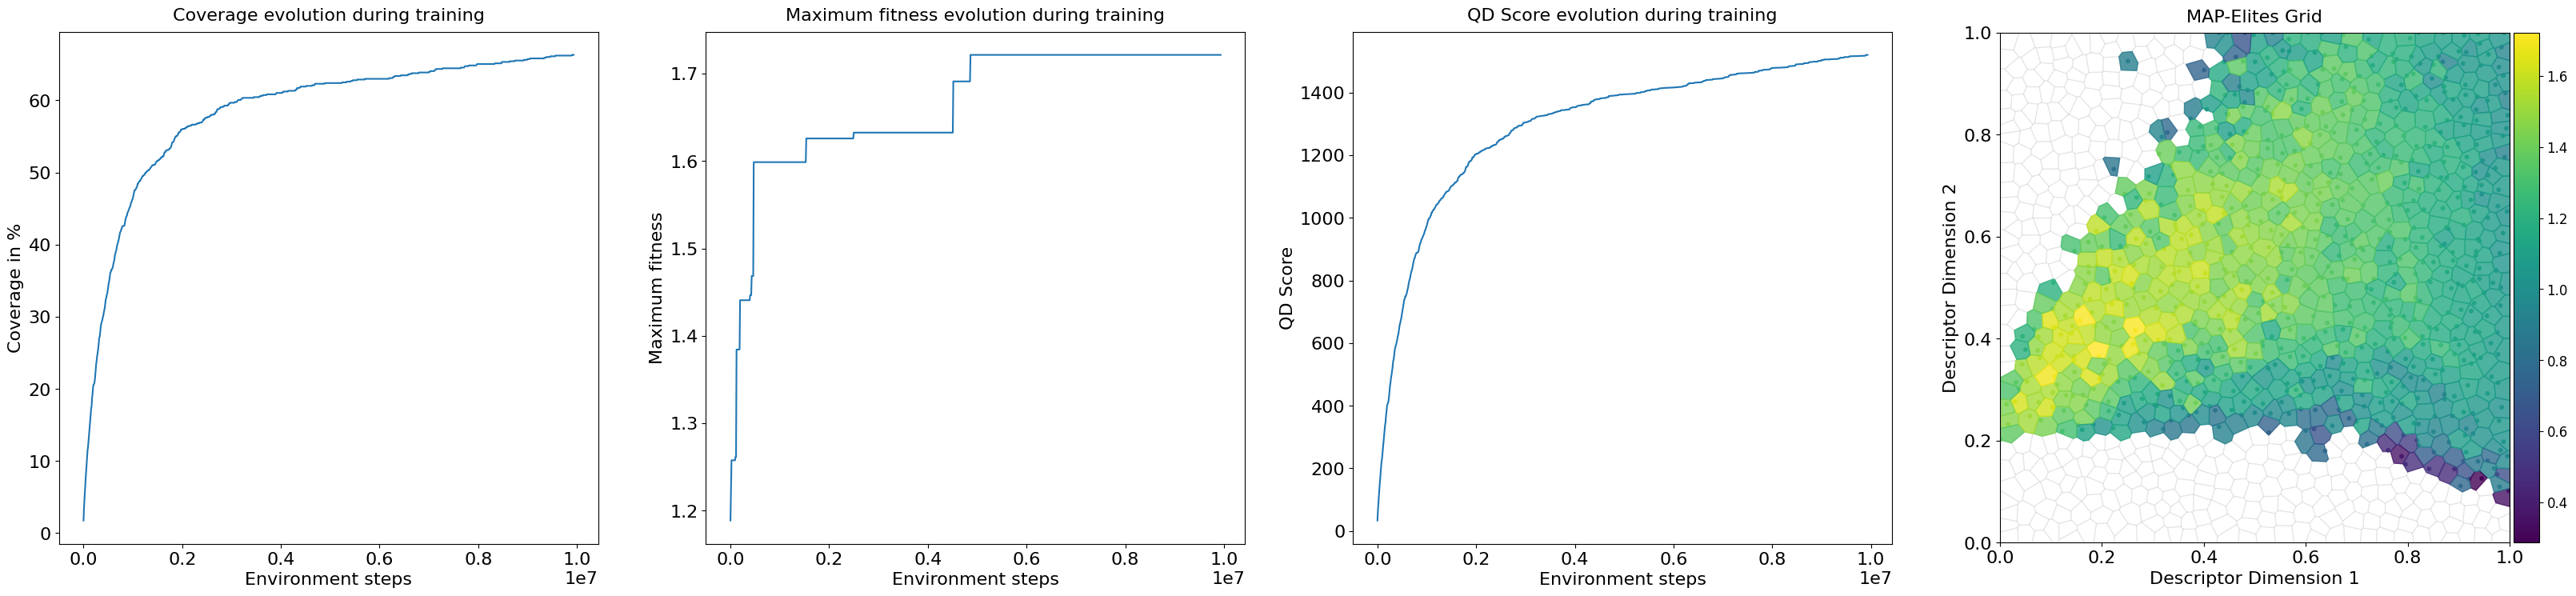

In [24]:
# Create the x-axis array
#env_steps = metrics["iteration"]
env_steps = metrics["iteration"] * batch_size * episode_length * config["NUM_ENVS"]
#print(jnp.max(env_steps))
#print(jnp.max(metrics["iteration"]))

%matplotlib inline
# Create the plots and the grid
fig, axes = plot_map_elites_results(env_steps=env_steps, metrics=metrics, repertoire=repertoire, min_descriptor=min_descriptor, max_descriptor=max_descriptor)

In [25]:
best_idx = jnp.argmax(repertoire.fitnesses)
best_fitness = jnp.max(repertoire.fitnesses)
best_descriptor = repertoire.descriptors[best_idx]
print(
    f"Best fitness in the repertoire: {best_fitness:.2f}\n",
    f"Descriptor of the best individual in the repertoire: {best_descriptor}\n",
    f"Index in the repertoire of this individual: {best_idx}\n"
)

Best fitness in the repertoire: 1.72
 Descriptor of the best individual in the repertoire: [0.19410875 0.36534745]
 Index in the repertoire of this individual: 161



In [26]:
# select the parameters of the best individual
my_params = jax.tree.map(
    lambda x: x[best_idx],
    repertoire.genotypes
)

In [27]:
import matplotlib.animation as animation

class Visualizer(object):
    def __init__(
        self,
        env: MultiAgentEnv,
        state_seq,
        reward_seq=None,
    ):
        self.env = env
        self.interval = 64

        # ✅ Preload data to CPU to avoid GPU-to-CPU transfers during animation
        self.state_seq = jax.device_get(state_seq)
        self.reward_seq = jax.device_get(reward_seq) if reward_seq is not None else None

        self.fig, self.ax = plt.subplots(1, 1, figsize=(6, 5))

    def animate(
        self,
        save_fname: Optional[str] = None,
        view: bool = True,
    ):
        ani = animation.FuncAnimation(
            self.fig,
            self.update,
            frames=len(self.state_seq),
            init_func=self.init,
            blit=True,  # ✅ Enables fast rendering
            interval=self.interval,
        )

        if save_fname is not None:
            ani.save(save_fname)

        if view:
            plt.show(block=True)

    def init(self):
        self.im = self.env.init_render(self.ax, self.state_seq[0])
        return [self.im]  # ✅ Required for blitting

    def update(self, frame):
        self.im = self.env.update_render(self.im, self.state_seq[frame])
        return [self.im]  # ✅ Required for blitting


class SMAXVisualizer(Visualizer):
    def __init__(
        self,
        env: MultiAgentEnv,
        state_seq,
        reward_seq=None,
    ):
        self.env = env
        self.raw_state_seq = state_seq  # GPU array until expanded
        self.reward_seq = reward_seq
        self.interval = 64
        self.have_expanded = False
        self.heuristic_enemy = isinstance(env, EnemySMAX)
        self.fig, self.ax = plt.subplots(1, 1, figsize=(6, 5))

    def expand_state_seq(self):
        """Expands the state sequence for higher frame resolution."""
        expanded = self.env.expand_state_seq(self.raw_state_seq)
        self.state_seq = jax.device_get(expanded)  # ✅ Preload to CPU
        self.have_expanded = True

    def animate(self, save_fname: Optional[str] = None, view: bool = True):
        if not self.have_expanded:
            self.expand_state_seq()
        return super().animate(save_fname, view)

    def init(self):
        self.im = self.env.init_render(self.ax, self.state_seq[0], 0, 0)
        return [self.im]  # ✅ Required for blitting

    def update(self, frame):
        self.im = self.env.update_render(
            self.im,
            self.state_seq[frame],
            frame % self.env.world_steps_per_env_step,
            frame // self.env.world_steps_per_env_step,
        )
        return [self.im]  # ✅ Required for blitting

In [ ]:
def preprocess_obs_with_id(obs_dict, env):
    """Simulate CTRolloutManager's preprocessing by adding one-hot agent IDs."""
    new_obs_dict = {}
    num_agents = len(env.agents)
    for i, agent in enumerate(env.agents):
        obs = obs_dict[agent].flatten()
        one_hot = jax.nn.one_hot(i, num_classes=num_agents)
        new_obs_dict[agent] = jnp.concatenate([obs, one_hot])
    return new_obs_dict


def visualize_recurrent_policy(trained_params, env, config):
    rng = jax.random.PRNGKey(config["SEED"])
    rng, reset_rng = jax.random.split(rng)
    #wrapped_env = CTRolloutManager(env, batch_size=1)

    # Create policy network
    #network = RNNQNetwork(
    #    action_dim=wrapped_env.max_action_space,
    #    hidden_dim=config["HIDDEN_SIZE"],
    #)
    network = RNNQNetwork(
        action_dim=env.action_space(env.agents[0]).n,
        hidden_dim=config["HIDDEN_SIZE"],
    )
    
    # Reset environment
    #obs, env_state = wrapped_env.batch_reset(reset_rng)
    obs, env_state = env.reset(reset_rng)
    #dones = {
    #    agent: jnp.zeros((1), dtype=bool)
    #    for agent in env.agents + ["__all__"]
    #}
    dones = {agent: jnp.array(False) for agent in env.agents}
    hstate = ScannedRNN.initialize_carry(
        config["HIDDEN_SIZE"], len(env.agents), 1
    )
    
    # Collect all environment states
    returns = {agent: 0.0 for agent in env.agents}
    state_seq = []
    max_steps = config["NUM_STEPS"]

    for step in range(max_steps):
        # Compute Q-values
        # Prepare inputs for network
        obs = preprocess_obs_with_id(obs, env)
        _obs = batchify(obs)         # (num_agents, obs_dim)
        _obs = _obs[:, None, :]                      # (num_agents, 1, obs_dim)

        #_dones = batchify(dones)    # (num_agents,)
        #_dones = _dones[:, None]                     # (num_agents, 1)
        _dones = jnp.stack([jnp.array([dones[agent]]) for agent in env.agents])  # shape (num_agents, 1)
        _dones = jnp.expand_dims(_dones, axis=-1)  # from (3, 1) to (3, 1, 1)

        #print("_obs.shape:", _obs.shape)
        #print("_dones.shape:", _dones.shape)
        #print("hstate.shape:", hstate.shape)

        def apply_fn(h, o, d):
            return network.apply(trained_params, h, o, d)

        hstate, q_vals = jax.vmap(apply_fn, in_axes=(0, 0, 0))(
            hstate,
            _obs,
            _dones,
        )
        #print("hstate.shape:", hstate.shape)

        #hstate = hstate[:, None, :]  # Already in (num_agents, hidden_dim)
        q_vals = q_vals.squeeze(axis=1)  # (num_agents, num_envs, num_actions) remove the time dim
        #print("q_vals.shape", q_vals.shape)
        
        actions = {}
        #avail_actions = wrapped_env.get_valid_actions(env_state.env_state)
        avail_actions = env.get_avail_actions(env_state.env_state)

        for i, agent in enumerate(env.agents):
            avail_agent = avail_actions[agent][None, None, :]  # shape (1, 1, n_actions)
            #print("avail_agent.shape", avail_agent.shape)
            
            unavail_actions = 1 - avail_agent  # shape (1, 1, n_actions)
            
            # Select Q-values for this agent only
            q_agent = q_vals[i][None, None, :]  # shape (1, 1, n_actions)
            q_masked = q_agent - (unavail_actions * 1e10)

            action = jnp.argmax(q_masked, axis=-1)  # shape (1, 1)
            action = action.squeeze()               # scalar
            #print("action.shape", action.shape)

            # Wrap in array with batch dim
            actions[agent] = int(action)    # shape (1,)
        
        rng, rng_s = jax.random.split(rng)
        state_seq.append((rng_s, env_state.env_state, actions))

        # Step environment

        # Batch the actions dict
        # Original actions: {'ally_0': 4, 'ally_1': 4, 'ally_2': 4}
        #actions = {k: jnp.array([v]) for k, v in actions.items()}

        #obs, env_state, rewards, dones, infos = wrapped_env.batch_step(
        #    rng_s, env_state, actions
        #)
        obs, env_state, rewards, dones, infos = env.step(rng_s, env_state, actions)
        returns = {a: returns[a] + rewards[a] for a in env.agents}
        
        if dones["__all__"]:
            break

    # Visualization
    print("Returns:", returns)

    viz = SMAXVisualizer(env, state_seq)
    viz.animate(view=False, save_fname="trained_qmix_rnn.gif")

Returns: {'ally_0': Array(0.40875006, dtype=float32), 'ally_1': Array(0.40875006, dtype=float32), 'ally_2': Array(0.40875006, dtype=float32), 'ally_3': Array(0.40875006, dtype=float32), 'ally_4': Array(0.40875006, dtype=float32)}


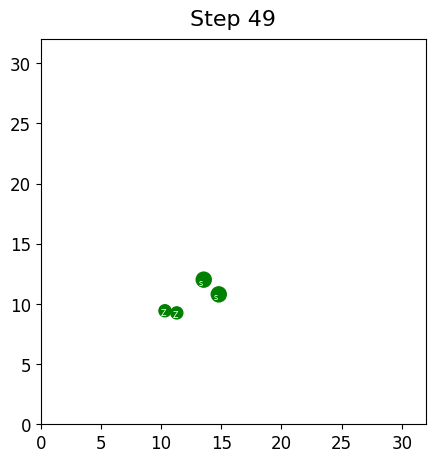

In [29]:
scenario = map_name_to_scenario(config["MAP_NAME"])
#env = HeuristicEnemySMAX(scenario=scenario, **config["ENV_KWARGS"])
#env = SMAXLogWrapper(env)
env = wrapped_env

visualize_recurrent_policy(my_params['agent'], env, config)

In [30]:
import pickle
from flax.serialization import to_state_dict
from flax.serialization import from_state_dict


def save_repertoire(repertoire: MapElitesRepertoire, filepath: str):
    # Convert the object to a savable dictionary
    state_dict = {
        "genotypes": to_state_dict(repertoire.genotypes),
        "fitnesses": repertoire.fitnesses,
        "descriptors": repertoire.descriptors,
        "centroids": repertoire.centroids,
        "extra_scores": to_state_dict(repertoire.extra_scores),
        "keys_extra_scores": repertoire.keys_extra_scores,
    }
    
    with open(filepath, "wb") as f:
        pickle.dump(state_dict, f)

def load_repertoire(filepath: str) -> MapElitesRepertoire:
    with open(filepath, "rb") as f:
        state_dict = pickle.load(f)

    # Rebuild the object using the saved state
    genotypes = from_state_dict(state_dict["genotypes"], state_dict["genotypes"])
    extra_scores = from_state_dict(state_dict["extra_scores"], state_dict["extra_scores"])

    return MapElitesRepertoire(
        genotypes=genotypes,
        fitnesses=state_dict["fitnesses"],
        descriptors=state_dict["descriptors"],
        centroids=state_dict["centroids"],
        extra_scores=extra_scores,
        keys_extra_scores=state_dict["keys_extra_scores"],
    )

In [31]:
#import os

#os.makedirs("/vol/bitbucket/eww24/Masters_project/repertoire", exist_ok=True)

filepath = "/vol/bitbucket/eww24/Masters_project/repertoire/qmix_reportoire.pkl"
save_repertoire(repertoire, filepath)
print("saved reportoire")

saved reportoire


In [32]:
loaded_repertoire = load_repertoire(filepath)
print("Repertoire loaded successfully.")

Repertoire loaded successfully.


In [33]:
best_idx = jnp.argmax(loaded_repertoire.fitnesses)
best_fitness = jnp.max(loaded_repertoire.fitnesses)
best_descriptor = loaded_repertoire.descriptors[best_idx]
print(
    f"Best fitness in the repertoire: {best_fitness:.2f}\n",
    f"Descriptor of the best individual in the repertoire: {best_descriptor}\n",
    f"Index in the repertoire of this individual: {best_idx}\n"
)

Best fitness in the repertoire: 1.72
 Descriptor of the best individual in the repertoire: [0.19410875 0.36534745]
 Index in the repertoire of this individual: 161

